In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.layers import (Flatten, Dense, BatchNormalization, Dropout, Reshape,
                                     Input, Activation, Conv2D, MaxPooling2D, UpSampling2D,
                                     Embedding, concatenate, multiply)
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras_preprocessing import image
from tensorflow.keras.datasets import mnist, cifar10, fashion_mnist

from google.colab import files

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
img_width, img_height, img_chann = 32, 32, 3
img_shape = (img_width, img_height, img_chann)
latent_dim = 100
batch_size = 128
optimizer = Adam(0.0001, 0.5)

In [57]:
# Создаем генератор
def create_generator():
    generator = Sequential([
                            Dense(64, input_dim=latent_dim),
                            LeakyReLU(alpha=0.2),
                            BatchNormalization(momentum=0.8),
                            Dense(128),
                            LeakyReLU(alpha=0.2),
                            BatchNormalization(momentum=0.8),
                            Dense(256),
                            LeakyReLU(alpha=0.2),
                            BatchNormalization(momentum=0.8),
                            Dense(512),
                            LeakyReLU(alpha=0.2),
                            BatchNormalization(momentum=0.8),
                            Dense(1024),
                            LeakyReLU(alpha=0.2),
                            BatchNormalization(momentum=0.8),
                            Dense(np.prod(img_shape), activation='tanh'),
                            Reshape(img_shape),
                            ])
    
    noise = Input(shape=(latent_dim,))
    img_gen = generator(noise)

    generator = Model(noise, img_gen)

    return generator

In [58]:
# Запускаям генератор и смотрим summary
gen = create_generator()
gen.summary()

Model: "model_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
sequential_30 (Sequential)   (None, 32, 32, 3)         3861440   
Total params: 3,861,440
Trainable params: 3,857,472
Non-trainable params: 3,968
_________________________________________________________________


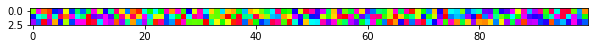

In [7]:
# Генерируем и смотрим шум необученного генератора
input_rand = np.random.random(size=(3, 100))   # size= не обязательно
plt.figure(figsize=(10, 8))
plt.imshow(input_rand, cmap='hsv')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


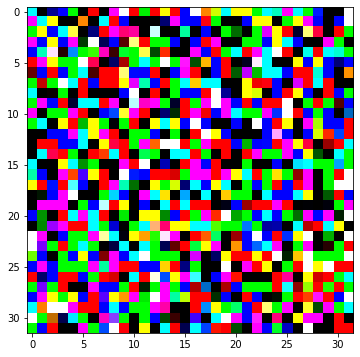

In [8]:
# Генерируем и смотрим predict из шума необученного генератора
predict_noise = gen.predict(input_rand) * 127.5 -1
plt.figure(figsize=(6, 6))
plt.imshow(predict_noise[0].reshape(32, 32, 3), cmap='hsv')
plt.show()

In [69]:
# Создаем дискриминатор
def create_discriminator():
    discriminator = Sequential([
                                Flatten(input_shape=img_shape),
                                #Dense(64),
                                #LeakyReLU(alpha=0.2),
                                #Dense(128),
                                #LeakyReLU(alpha=0.2),
                                #Dense(256),
                                #LeakyReLU(alpha=0.2),
                                #Dense(512),
                                #LeakyReLU(alpha=0.2),
                                #BatchNormalization(momentum=0.8),
                                Dense(768),
                                LeakyReLU(alpha=0.2),
                                #BatchNormalization(momentum=0.8),
                                Dense(1024),
                                LeakyReLU(alpha=0.2),
                                Dense(2048),
                                LeakyReLU(alpha=0.2),
                                #Dense(32),
                                #LeakyReLU(alpha=0.2),
                                Dense(3, activation='sigmoid')
                                ])
    img_discr = Input(shape=img_shape)
    validity_discr = discriminator(img_discr)
    
    discriminator = Model(img_discr, validity_discr)
    
    # Компилируем дискриминатор
    discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # замораживаем обучение дискриминатора
    discriminator.trainable=False

    return discriminator

In [70]:
# Запускаем дискриминатор и смотрим summary
discr = create_discriminator()
discr.summary()

Model: "model_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_53 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_39 (Sequential)   (None, 3)                 5252867   
Total params: 5,252,867
Trainable params: 0
Non-trainable params: 5,252,867
_________________________________________________________________


In [13]:
# Предсказание для необученного дискриминатора
predict_discr = discr.predict(predict_noise)
predict_discr

array([[0.6595842],
       [0.9826081],
       [0.9321813]], dtype=float32)

In [88]:
# Загружаем и готовим набор
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.astype('float32')
X_train = (X_train - 127.5) / 127.5
#X_train = np.expand_dims(X_train, axis=0)
y_train = y_train.reshape(-1, 1)

In [17]:
X_train.shape

(50000, 32, 32, 3)

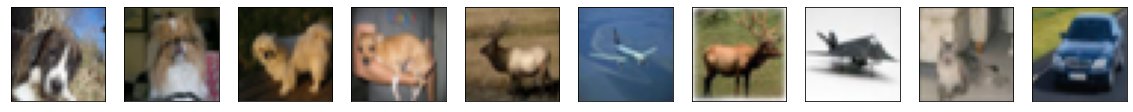

In [34]:
# Функция вывода оригинальных изображений
def image_origin(X_train):
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        index = np.random.randint(0, X_train.shape[0])
        ax=plt.subplot(1, n, i + 1)

        plt.imshow(X_train[index].reshape((32, 32, 3)))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

image_origin(X_test)

In [18]:
# Удаляем старый каталог
!rm -R '/content/images'
# Создаем каталог 'images'
!mkdir images

In [27]:
# Вывод изображений при предсказании
def sample_images(epoch, gen):
    row, col = 2, 5
    noise = np.random.normal(0, 1, (row * col, latent_dim))
    gen_images = gen.predict(noise)
    gen_images = 0.5 * gen_images + 0.5

    fig, axs = plt.subplots(row, col, figsize=(12, 8))
    num_img = 0
    for i in range(row):
        for j in range(col):
            axs[i, j].imshow(gen_images[num_img, :,:,0], cmap='hsv')
            axs[i, j].axis('off')   # без названий осей
            num_img += 1

    plt.show()
    fig.savefig("images/%d.png" % epoch) 
    plt.close()

In [71]:
# Обучаем
epochs = 10000
def train(generator, discriminator, epochs=epochs, batch_size=batch_size):
    fake_0 = np.zeros((batch_size, 3))
    fake_1 = np.ones((batch_size, 3))
    
    z = Input(shape=(latent_dim,))
    img_gen = generator(z)
    validity_discr = discriminator(img_gen)

    # Создаем полносвязную сеть
    combined = Model(z, validity_discr)
    combined.compile(optimizer=optimizer, loss='binary_crossentropy')

    sample_interval = 250 # интервал вывода сгенерированных картинок

    discr_loss_list = []
    gen_loss_list = []
    discr_acc_list = []
    
    # тренируем дискриминатор
    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise)

        discr_loss_real = discriminator.train_on_batch(imgs, fake_1)
        discr_loss_fake = discriminator.train_on_batch(gen_imgs, fake_0)
        discr_loss = 0.5 * np.add(discr_loss_real, discr_loss_fake)

    # Обучам всю модель при замороженном дискриминаторе
        gen_loss = combined.train_on_batch(noise, fake_1)

        print(f'Epoch: {epoch}  |  Discr loss: {discr_loss[0]:.4f}  |  Discr acc: {100*discr_loss[1]:.2f} %  |  Gen loss: {gen_loss:.4f}')
        
        discr_loss_list.append(discr_loss[0])
        gen_loss_list.append(gen_loss)
        discr_acc_list.append(discr_loss[1]*100)

        if ((epoch % sample_interval == 0) | (epoch == epochs-1)):
            sample_images(epoch, generator)

    # выводим графики Ошибок дискриминатора и генератора, точности распознавания
    plt.figure(figsize=(20, 10))
    
    plt.subplot(1, 2, 1)
    plt.plot(discr_loss_list, label='Ошибка Дискриминатора')
    plt.plot(gen_loss_list, label='Ошибка Генератора')
    plt.title('Показатель ошибки', fontsize=16)
    plt.xlabel('Эпоха', fontsize=12)
    plt.ylabel('Верные ответы', fontsize=12)
    plt.grid()
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(discr_acc_list, label='Точность Дискриминатора')
    plt.title('Показатель точности', fontsize=16)
    plt.xlabel('Эпоха', fontsize=12)
    plt.ylabel('Верные ответы', fontsize=12)    
    plt.grid()
    plt.legend()
    plt.show()

In [72]:
# Запускаем Функции
generator = create_generator()
discriminator = create_discriminator()
train(generator, discriminator, epochs=epochs)

Output hidden; open in https://colab.research.google.com to view.

In [77]:
num_classes = 10

In [79]:
# Создаем генератор
def create_generator_cgan2():
    generator = Sequential([
                            Dense(128, input_dim=latent_dim),
                            LeakyReLU(alpha=0.2),
                            BatchNormalization(momentum=0.8),
                            Dense(256),
                            LeakyReLU(alpha=0.2),
                            BatchNormalization(momentum=0.8),
                            Dense(512),
                            LeakyReLU(alpha=0.2),
                            BatchNormalization(momentum=0.8),
                            Dense(768),
                            LeakyReLU(alpha=0.2),
                            BatchNormalization(momentum=0.8),
                            Dense(1024),
                            LeakyReLU(alpha=0.2),
                            BatchNormalization(momentum=0.8),
                            Dense(2048),
                            LeakyReLU(alpha=0.2),
                            BatchNormalization(momentum=0.8),
                            Dense(np.prod(img_shape), activation='tanh'),
                            Reshape(img_shape),
                            ])
    
    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,), dtype='int32')
    label_embeding_gen = Flatten()(Embedding(num_classes, latent_dim)(label))

    model_inp_generator = multiply([noise, label_embeding_gen])
    img_gen = generator(model_inp_generator)

    generator = Model([noise, label], img_gen)

    return generator


In [80]:
# Запускаям генератор и смотрим summary
gen_cgan2 = create_generator_cgan2()
gen_cgan2.summary()

Model: "model_56"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_62 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       1000        input_62[0][0]                   
__________________________________________________________________________________________________
input_61 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
flatten_27 (Flatten)            (None, 100)          0           embedding[0][0]                  
___________________________________________________________________________________________

In [82]:
# Создаем дискриминатор
def create_discriminator_cgan2():
    discriminator = Sequential([
                                Flatten(input_shape=img_shape),
                                Dense(1024),
                                LeakyReLU(alpha=0.2),
                                Dense(768),
                                LeakyReLU(alpha=0.2),
                                Dense(256),
                                LeakyReLU(alpha=0.2),
                                #BatchNormalization(momentum=0.8),
                                Dense(128),
                                LeakyReLU(alpha=0.2),
                                #BatchNormalization(momentum=0.8),
                                #Dense(64),
                                #LeakyReLU(alpha=0.2),
                                Dense(1, activation='sigmoid')
                                ])
    img_discr = Input(shape=img_shape)
    label = Input(shape=(1,), dtype='int32')
    label_embeding_discr = Flatten()(Embedding(num_classes, np.prod(img_shape))(label))

    img_flat = Flatten()(img_discr)

    model_inp_discriminator = multiply([img_flat, label_embeding_discr])

    validity_discr = discriminator(model_inp_discriminator)
    
    discriminator = Model([img_discr, label], validity_discr)
    
    # Компилируем дискриминатор
    discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # замораживаем обучение дискриминатора
    discriminator.trainable=False

    return discriminator

In [83]:
# Запускаем дискриминатор и смотрим summary
discr_cgan2 = create_discriminator_cgan2()
discr_cgan2.summary()

Model: "model_57"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_64 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_63 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 3072)      30720       input_64[0][0]                   
__________________________________________________________________________________________________
flatten_30 (Flatten)            (None, 3072)         0           input_63[0][0]                   
___________________________________________________________________________________________

In [84]:
# Удаляем старый каталог
!rm -R '/content/images'
# Создаем каталог 'images'
!mkdir images

In [85]:
# Вывод изображений при предсказании
def sample_images(epoch, gen):
    row, col = 2, 5
    noise = np.random.normal(0, 1, (row * col, latent_dim))
    sample_labels = np.arange(0, 10).reshape(-1, 1)
    gen_images = gen.predict([noise, sample_labels])
    gen_images = 0.5 * gen_images + 0.5

    fig, axs = plt.subplots(row, col, figsize=(12, 8))
    num_img = 0
    for i in range(row):
        for j in range(col):
            axs[i, j].imshow(gen_images[num_img, :,:,0], cmap='hsv')
            axs[i, j].axis('off')   # без названий осей
            num_img += 1

    plt.show()
    fig.savefig("images/%d.png" % epoch) 
    plt.close()

In [89]:
# Обучаем
epochs = 10000
def train_cgan2(generator, discriminator, epochs=epochs, batch_size=batch_size):
    fake_0 = np.zeros((batch_size, 1))
    fake_1 = np.ones((batch_size, 1))
        
    z = Input(shape=(latent_dim,))
    label = Input(shape=(1,))
    img_gen = generator([z, label])
    validity_discr = discriminator([img_gen, label])

    # Создаем полносвязную сеть
    combined = Model([z, label], validity_discr)
    combined.compile(optimizer=optimizer, loss=['binary_crossentropy'])

    sample_interval = 250 # интервал вывода сгенерированных картинок

    discr_loss_list = []
    gen_loss_list = []
    discr_acc_list = []
    
    # тренируем дискриминатор
    for epoch in range(epochs):
        
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], y_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict([noise, labels])

        discr_loss_real = discriminator.train_on_batch([imgs, labels], fake_1)
        discr_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake_0)
        discr_loss = 0.5 * np.add(discr_loss_real, discr_loss_fake)

    # Обучам всю модель при замороженном дискриминаторе
        sample_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

        gen_loss = combined.train_on_batch([noise, sample_labels], fake_1)

        print(f'Epoch: {epoch}  |  Discr loss: {discr_loss[0]:.4f}  |  Discr acc: {100*discr_loss[1]:.2f}%  |  Gen loss: {gen_loss:.4f}')
        
        discr_loss_list.append(discr_loss[0])
        gen_loss_list.append(gen_loss)
        discr_acc_list.append(discr_loss[1]*100)

        if ((epoch % sample_interval == 0) | (epoch == epochs-1)):
            sample_images(epoch, generator)

    # выводим графики Ошибок дискриминатора и генератора, точности распознавания
    plt.figure(figsize=(20, 10))
    
    plt.subplot(1, 2, 1)
    plt.plot(discr_loss_list, label='Ошибка Дискриминатора')
    plt.plot(gen_loss_list, label='Ошибка Генератора')
    plt.title('Показатель ошибки', fontsize=16)
    plt.xlabel('Эпоха', fontsize=12)
    plt.ylabel('Верные ответы', fontsize=12)
    plt.grid()
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(discr_acc_list, label='Точность Дискриминатора')
    plt.title('Показатель точности', fontsize=16)
    plt.xlabel('Эпоха', fontsize=12)
    plt.ylabel('Верные ответы', fontsize=12)    
    plt.grid()
    plt.legend()
    plt.show()

In [90]:
# Запускаем Функции
generator_cgan2 = create_generator_cgan2()
discriminator_cgan2 = create_discriminator_cgan2()
train_cgan2(generator_cgan2, discriminator_cgan2, epochs=epochs)

Output hidden; open in https://colab.research.google.com to view.

1 цифра из mnist

In [ ]:
# Удаляем старый каталог
!rm -R '/content/images'
# Создаем каталог 'images'
!mkdir images

In [ ]:
# Берем изображение цифры 7
y_7 = y_train_mnist[y_train_mnist == 7]

In [ ]:
y_7, y_7.shape

(array([7, 7, 7, ..., 7, 7, 7], dtype=uint8), (6265,))

In [ ]:
# Создаем генератор
def create_generator_cgan2():
    generator = Sequential([
                            Dense(128, input_dim=latent_dim),
                            LeakyReLU(alpha=0.2),
                            BatchNormalization(momentum=0.8),
                            Dense(256),
                            LeakyReLU(alpha=0.2),
                            BatchNormalization(momentum=0.8),
                            Dense(512),
                            LeakyReLU(alpha=0.2),
                            BatchNormalization(momentum=0.8),
                            Dense(768),
                            LeakyReLU(alpha=0.2),
                            BatchNormalization(momentum=0.8),
                            Dense(1024),
                            LeakyReLU(alpha=0.2),
                            BatchNormalization(momentum=0.8),
                            Dense(2048),
                            LeakyReLU(alpha=0.2),
                            BatchNormalization(momentum=0.8),
                            Dense(np.prod(img_shape), activation='tanh'),
                            Reshape(img_shape),
                            ])
    
    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,), dtype='int32')
    label_embeding_gen = Flatten()(Embedding(num_classes, latent_dim)(label))

    model_inp_generator = multiply([noise, label_embeding_gen])
    img_gen = generator(model_inp_generator)

    generator = Model([noise, label], img_gen)

    return generator

In [ ]:
# Запускаям генератор и смотрим summary
gen_cgan2 = create_generator_cgan2()
gen_cgan2.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 100)       1000        input_12[0][0]                   
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
flatten_8 (Flatten)             (None, 100)          0           embedding_4[0][0]                
____________________________________________________________________________________________

In [ ]:
# Создаем дискриминатор
def create_discriminator_cgan2():
    discriminator = Sequential([
                                Flatten(input_shape=img_shape),
                                Dense(1024),
                                LeakyReLU(alpha=0.2),
                                Dense(768),
                                LeakyReLU(alpha=0.2),
                                Dense(256),
                                LeakyReLU(alpha=0.2),
                                #BatchNormalization(momentum=0.8),
                                Dense(128),
                                LeakyReLU(alpha=0.2),
                                #BatchNormalization(momentum=0.8),
                                #Dense(64),
                                #LeakyReLU(alpha=0.2),
                                Dense(1, activation='sigmoid')
                                ])
    img_discr = Input(shape=img_shape)
    label = Input(shape=(1,), dtype='int32')
    label_embeding_discr = Flatten()(Embedding(num_classes, np.prod(img_shape))(label))

    img_flat = Flatten()(img_discr)

    model_inp_discriminator = multiply([img_flat, label_embeding_discr])

    validity_discr = discriminator(model_inp_discriminator)
    
    discriminator = Model([img_discr, label], validity_discr)
    
    # Компилируем дискриминатор
    discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # замораживаем обучение дискриминатора
    discriminator.trainable=False

    return discriminator

In [ ]:
# Запускаем дискриминатор и смотрим summary
discr_cgan2 = create_discriminator_cgan2()
discr_cgan2.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 784)       7840        input_14[0][0]                   
__________________________________________________________________________________________________
flatten_11 (Flatten)            (None, 784)          0           input_13[0][0]                   
____________________________________________________________________________________________

In [ ]:
# Вывод изображений при предсказании
def sample_images(epoch, gen):
    row, col = 2, 5
    noise = np.random.normal(0, 1, (row * col, latent_dim))
    sample_labels = np.arange(0, 10).reshape(-1, 1)
    gen_images = gen.predict([noise, sample_labels])
    gen_images = 0.5 * gen_images + 0.5

    fig, axs = plt.subplots(row, col, figsize=(12, 8))
    num_img = 0
    for i in range(row):
        for j in range(col):
            axs[i, j].imshow(gen_images[num_img, :,:,0], cmap='gray')
            axs[i, j].axis('off')   # без названий осей
            num_img += 1

    plt.show()
    fig.savefig("images/%d.png" % epoch) 
    plt.close()

In [ ]:
# Обучаем
epochs = 10000
def train_cgan2(generator, discriminator, epochs=epochs, batch_size=batch_size):
    fake_0 = np.zeros((batch_size, 1))
    fake_1 = np.ones((batch_size, 1))
        
    z = Input(shape=(latent_dim,))
    label = Input(shape=(1,))
    img_gen = generator([z, label])
    validity_discr = discriminator([img_gen, label])

    # Создаем полносвязную сеть
    combined = Model([z, label], validity_discr)
    combined.compile(optimizer=optimizer, loss=['binary_crossentropy'])

    sample_interval = 250 # интервал вывода сгенерированных картинок

    discr_loss_list = []
    gen_loss_list = []
    discr_acc_list = []
    
    # тренируем дискриминатор
    for epoch in range(epochs):
        
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        idy = np.random.randint(0, X_train_mnist[0:5842].shape[0], batch_size)
        labels = y_7[idy]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict([noise, labels])

        discr_loss_real = discriminator.train_on_batch([imgs, labels], fake_1)
        discr_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake_0)
        discr_loss = 0.5 * np.add(discr_loss_real, discr_loss_fake)

    # Обучам всю модель при замороженном дискриминаторе
        sample_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

        gen_loss = combined.train_on_batch([noise, sample_labels], fake_1)

        print(f'Epoch: {epoch}  |  Discr loss: {discr_loss[0]:.4f}  |  Discr acc: {100*discr_loss[1]:.2f}  |  Gen loss: {gen_loss:.4f}')
        
        discr_loss_list.append(discr_loss[0])
        gen_loss_list.append(gen_loss)
        discr_acc_list.append(discr_loss[1]*100)

        if ((epoch % sample_interval == 0) | (epoch == epochs-1)):
            sample_images(epoch, generator)

    # выводим графики Ошибок дискриминатора и генератора, точности распознавания
    plt.figure(figsize=(20, 10))
    
    plt.subplot(1, 2, 1)
    plt.plot(discr_loss_list, label='Ошибка Дискриминатора')
    plt.plot(gen_loss_list, label='Ошибка Генератора')
    plt.title('Показатель ошибки', fontsize=16)
    plt.xlabel('Эпоха', fontsize=12)
    plt.ylabel('Верные ответы', fontsize=12)
    plt.grid()
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(discr_acc_list, label='Точность Дискриминатора')
    plt.title('Показатель точности', fontsize=16)
    plt.xlabel('Эпоха', fontsize=12)
    plt.ylabel('Верные ответы', fontsize=12)    
    plt.grid()
    plt.legend()
    plt.show()

Epoch: 0  |  Discr loss: 0.6950  |  Discr acc: 10.16  |  Gen loss: 0.6868


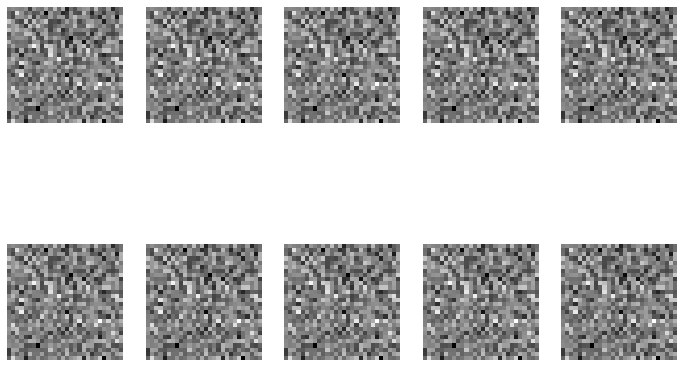

Epoch: 1  |  Discr loss: 0.6865  |  Discr acc: 50.00  |  Gen loss: 0.6824
Epoch: 2  |  Discr loss: 0.6782  |  Discr acc: 50.00  |  Gen loss: 0.6786
Epoch: 3  |  Discr loss: 0.6689  |  Discr acc: 50.39  |  Gen loss: 0.6753
Epoch: 4  |  Discr loss: 0.6559  |  Discr acc: 100.00  |  Gen loss: 0.6711
Epoch: 5  |  Discr loss: 0.6381  |  Discr acc: 100.00  |  Gen loss: 0.6654
Epoch: 6  |  Discr loss: 0.6167  |  Discr acc: 100.00  |  Gen loss: 0.6568
Epoch: 7  |  Discr loss: 0.5895  |  Discr acc: 100.00  |  Gen loss: 0.6483
Epoch: 8  |  Discr loss: 0.5526  |  Discr acc: 100.00  |  Gen loss: 0.6386
Epoch: 9  |  Discr loss: 0.5055  |  Discr acc: 100.00  |  Gen loss: 0.6205
Epoch: 10  |  Discr loss: 0.4543  |  Discr acc: 100.00  |  Gen loss: 0.6054
Epoch: 11  |  Discr loss: 0.3991  |  Discr acc: 100.00  |  Gen loss: 0.5917
Epoch: 12  |  Discr loss: 0.3337  |  Discr acc: 100.00  |  Gen loss: 0.5687
Epoch: 13  |  Discr loss: 0.2857  |  Discr acc: 100.00  |  Gen loss: 0.5542
Epoch: 14  |  Discr loss

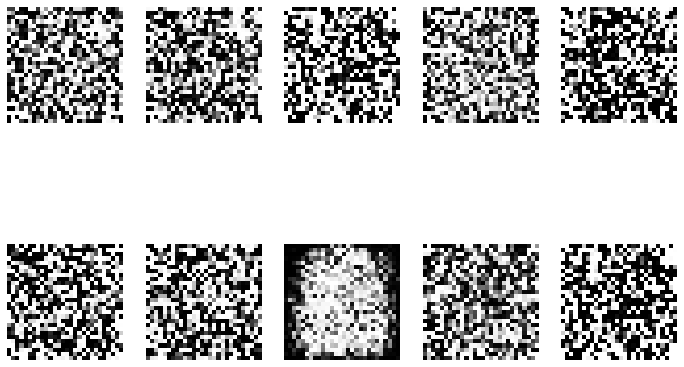

Epoch: 251  |  Discr loss: 0.1151  |  Discr acc: 94.53  |  Gen loss: 1.4142
Epoch: 252  |  Discr loss: 0.2146  |  Discr acc: 92.58  |  Gen loss: 1.4423
Epoch: 253  |  Discr loss: 0.1274  |  Discr acc: 96.09  |  Gen loss: 1.1378
Epoch: 254  |  Discr loss: 0.2572  |  Discr acc: 90.23  |  Gen loss: 1.5053
Epoch: 255  |  Discr loss: 0.1357  |  Discr acc: 94.53  |  Gen loss: 1.2544
Epoch: 256  |  Discr loss: 0.1499  |  Discr acc: 95.70  |  Gen loss: 1.0587
Epoch: 257  |  Discr loss: 0.0884  |  Discr acc: 96.48  |  Gen loss: 0.8800
Epoch: 258  |  Discr loss: 0.2354  |  Discr acc: 87.89  |  Gen loss: 1.6674
Epoch: 259  |  Discr loss: 0.3547  |  Discr acc: 83.20  |  Gen loss: 0.6450
Epoch: 260  |  Discr loss: 0.2333  |  Discr acc: 90.62  |  Gen loss: 1.0408
Epoch: 261  |  Discr loss: 0.0911  |  Discr acc: 96.48  |  Gen loss: 0.7997
Epoch: 262  |  Discr loss: 0.1297  |  Discr acc: 95.31  |  Gen loss: 0.6186
Epoch: 263  |  Discr loss: 0.2592  |  Discr acc: 88.28  |  Gen loss: 1.4431
Epoch: 264  

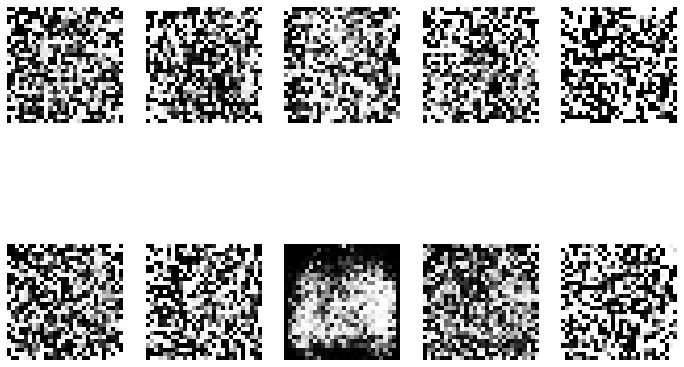

Epoch: 501  |  Discr loss: 0.3027  |  Discr acc: 89.45  |  Gen loss: 1.2004
Epoch: 502  |  Discr loss: 0.3940  |  Discr acc: 83.20  |  Gen loss: 1.1865
Epoch: 503  |  Discr loss: 0.5256  |  Discr acc: 76.56  |  Gen loss: 1.1648
Epoch: 504  |  Discr loss: 0.1978  |  Discr acc: 92.19  |  Gen loss: 1.2589
Epoch: 505  |  Discr loss: 0.3583  |  Discr acc: 86.72  |  Gen loss: 1.0400
Epoch: 506  |  Discr loss: 0.3009  |  Discr acc: 90.62  |  Gen loss: 1.2184
Epoch: 507  |  Discr loss: 0.3460  |  Discr acc: 86.33  |  Gen loss: 1.1907
Epoch: 508  |  Discr loss: 0.3799  |  Discr acc: 83.98  |  Gen loss: 1.6558
Epoch: 509  |  Discr loss: 0.3018  |  Discr acc: 87.11  |  Gen loss: 0.9666
Epoch: 510  |  Discr loss: 0.3674  |  Discr acc: 83.59  |  Gen loss: 1.6632
Epoch: 511  |  Discr loss: 0.2692  |  Discr acc: 89.84  |  Gen loss: 1.1080
Epoch: 512  |  Discr loss: 0.3315  |  Discr acc: 85.94  |  Gen loss: 1.1439
Epoch: 513  |  Discr loss: 0.3973  |  Discr acc: 82.42  |  Gen loss: 1.1871
Epoch: 514  

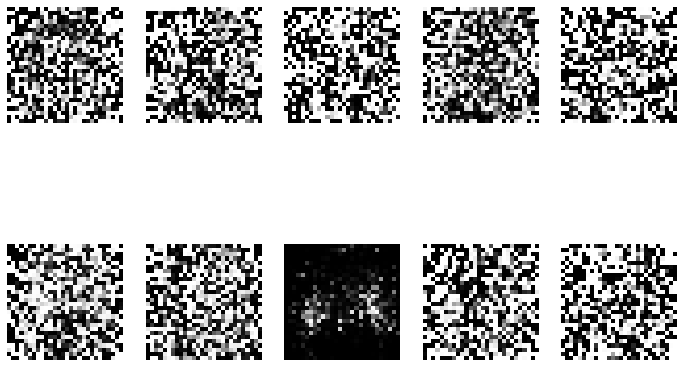

Epoch: 751  |  Discr loss: 0.4371  |  Discr acc: 78.12  |  Gen loss: 0.6240
Epoch: 752  |  Discr loss: 0.4009  |  Discr acc: 84.77  |  Gen loss: 0.6871
Epoch: 753  |  Discr loss: 0.3509  |  Discr acc: 86.72  |  Gen loss: 0.5084
Epoch: 754  |  Discr loss: 0.3550  |  Discr acc: 87.89  |  Gen loss: 0.7217
Epoch: 755  |  Discr loss: 0.3460  |  Discr acc: 84.77  |  Gen loss: 0.7697
Epoch: 756  |  Discr loss: 0.4653  |  Discr acc: 79.69  |  Gen loss: 0.5629
Epoch: 757  |  Discr loss: 0.4208  |  Discr acc: 84.38  |  Gen loss: 0.8576
Epoch: 758  |  Discr loss: 0.4330  |  Discr acc: 80.08  |  Gen loss: 0.7658
Epoch: 759  |  Discr loss: 0.4054  |  Discr acc: 84.77  |  Gen loss: 0.5600
Epoch: 760  |  Discr loss: 0.4440  |  Discr acc: 78.52  |  Gen loss: 0.5941
Epoch: 761  |  Discr loss: 0.3857  |  Discr acc: 81.64  |  Gen loss: 0.6069
Epoch: 762  |  Discr loss: 0.3542  |  Discr acc: 87.89  |  Gen loss: 0.7355
Epoch: 763  |  Discr loss: 0.3932  |  Discr acc: 85.16  |  Gen loss: 0.6924
Epoch: 764  

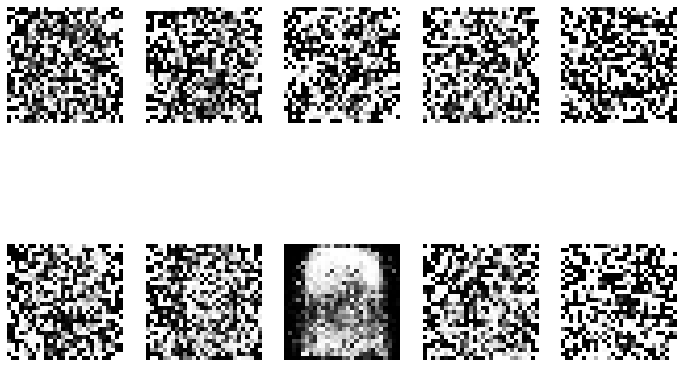

Epoch: 1001  |  Discr loss: 0.3711  |  Discr acc: 86.72  |  Gen loss: 0.2907
Epoch: 1002  |  Discr loss: 0.3764  |  Discr acc: 83.98  |  Gen loss: 0.1396
Epoch: 1003  |  Discr loss: 0.3268  |  Discr acc: 87.50  |  Gen loss: 0.2757
Epoch: 1004  |  Discr loss: 0.3648  |  Discr acc: 86.33  |  Gen loss: 0.3125
Epoch: 1005  |  Discr loss: 0.3288  |  Discr acc: 88.28  |  Gen loss: 0.1623
Epoch: 1006  |  Discr loss: 0.3396  |  Discr acc: 87.11  |  Gen loss: 0.3086
Epoch: 1007  |  Discr loss: 0.3287  |  Discr acc: 87.11  |  Gen loss: 0.3317
Epoch: 1008  |  Discr loss: 0.3618  |  Discr acc: 85.94  |  Gen loss: 0.2059
Epoch: 1009  |  Discr loss: 0.3410  |  Discr acc: 89.06  |  Gen loss: 0.1817
Epoch: 1010  |  Discr loss: 0.3172  |  Discr acc: 87.11  |  Gen loss: 0.2833
Epoch: 1011  |  Discr loss: 0.4248  |  Discr acc: 81.64  |  Gen loss: 0.2825
Epoch: 1012  |  Discr loss: 0.4721  |  Discr acc: 78.91  |  Gen loss: 0.3139
Epoch: 1013  |  Discr loss: 0.3846  |  Discr acc: 83.98  |  Gen loss: 0.3075

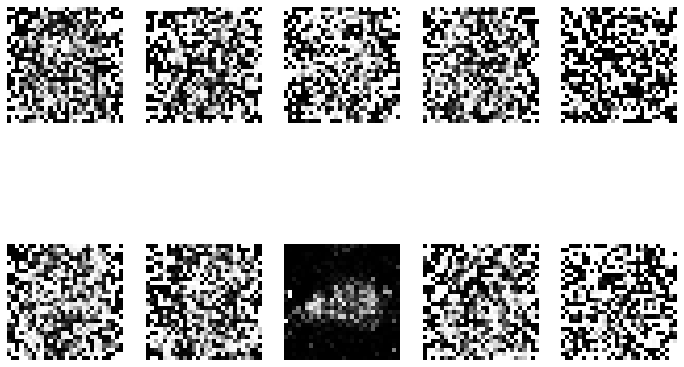

Epoch: 1251  |  Discr loss: 0.5701  |  Discr acc: 69.92  |  Gen loss: 0.3818
Epoch: 1252  |  Discr loss: 0.4100  |  Discr acc: 81.25  |  Gen loss: 0.2136
Epoch: 1253  |  Discr loss: 0.5334  |  Discr acc: 73.44  |  Gen loss: 0.3217
Epoch: 1254  |  Discr loss: 0.4356  |  Discr acc: 80.47  |  Gen loss: 0.1998
Epoch: 1255  |  Discr loss: 0.5314  |  Discr acc: 71.88  |  Gen loss: 0.2212
Epoch: 1256  |  Discr loss: 0.4317  |  Discr acc: 81.64  |  Gen loss: 0.2285
Epoch: 1257  |  Discr loss: 0.4902  |  Discr acc: 75.78  |  Gen loss: 0.1804
Epoch: 1258  |  Discr loss: 0.4932  |  Discr acc: 75.39  |  Gen loss: 0.1825
Epoch: 1259  |  Discr loss: 0.4272  |  Discr acc: 81.25  |  Gen loss: 0.2672
Epoch: 1260  |  Discr loss: 0.4035  |  Discr acc: 83.59  |  Gen loss: 0.2091
Epoch: 1261  |  Discr loss: 0.3616  |  Discr acc: 88.67  |  Gen loss: 0.2299
Epoch: 1262  |  Discr loss: 0.3939  |  Discr acc: 83.59  |  Gen loss: 0.1664
Epoch: 1263  |  Discr loss: 0.3541  |  Discr acc: 87.50  |  Gen loss: 0.2136

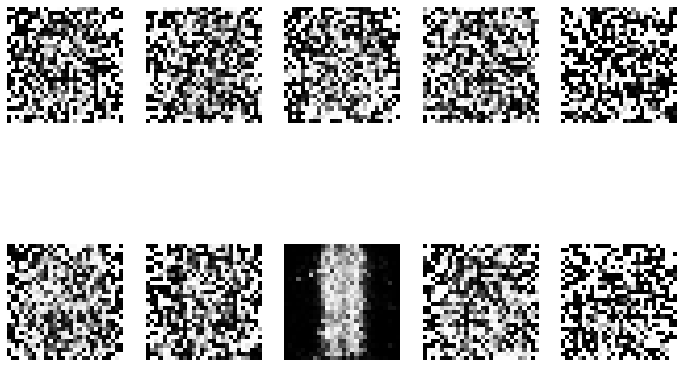

Epoch: 1501  |  Discr loss: 0.4819  |  Discr acc: 77.34  |  Gen loss: 0.2069
Epoch: 1502  |  Discr loss: 0.4417  |  Discr acc: 83.20  |  Gen loss: 0.2348
Epoch: 1503  |  Discr loss: 0.4526  |  Discr acc: 77.34  |  Gen loss: 0.2331
Epoch: 1504  |  Discr loss: 0.4279  |  Discr acc: 80.47  |  Gen loss: 0.2325
Epoch: 1505  |  Discr loss: 0.4595  |  Discr acc: 78.52  |  Gen loss: 0.2713
Epoch: 1506  |  Discr loss: 0.4641  |  Discr acc: 78.52  |  Gen loss: 0.2619
Epoch: 1507  |  Discr loss: 0.5047  |  Discr acc: 74.22  |  Gen loss: 0.2190
Epoch: 1508  |  Discr loss: 0.4681  |  Discr acc: 76.95  |  Gen loss: 0.2435
Epoch: 1509  |  Discr loss: 0.4516  |  Discr acc: 80.08  |  Gen loss: 0.1847
Epoch: 1510  |  Discr loss: 0.4947  |  Discr acc: 78.52  |  Gen loss: 0.2349
Epoch: 1511  |  Discr loss: 0.5128  |  Discr acc: 75.78  |  Gen loss: 0.3295
Epoch: 1512  |  Discr loss: 0.4953  |  Discr acc: 76.95  |  Gen loss: 0.2167
Epoch: 1513  |  Discr loss: 0.5334  |  Discr acc: 77.34  |  Gen loss: 0.2216

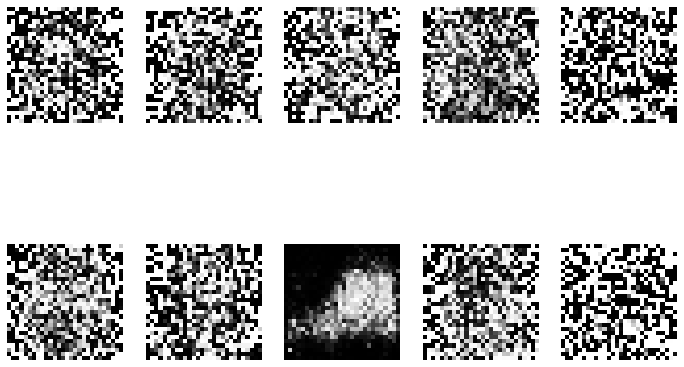

Epoch: 1751  |  Discr loss: 0.4864  |  Discr acc: 75.78  |  Gen loss: 0.2854
Epoch: 1752  |  Discr loss: 0.4860  |  Discr acc: 76.95  |  Gen loss: 0.2825
Epoch: 1753  |  Discr loss: 0.4559  |  Discr acc: 79.30  |  Gen loss: 0.3195
Epoch: 1754  |  Discr loss: 0.5648  |  Discr acc: 69.92  |  Gen loss: 0.2893
Epoch: 1755  |  Discr loss: 0.5029  |  Discr acc: 75.00  |  Gen loss: 0.3509
Epoch: 1756  |  Discr loss: 0.5545  |  Discr acc: 70.31  |  Gen loss: 0.2772
Epoch: 1757  |  Discr loss: 0.5485  |  Discr acc: 69.92  |  Gen loss: 0.2470
Epoch: 1758  |  Discr loss: 0.4913  |  Discr acc: 75.39  |  Gen loss: 0.2835
Epoch: 1759  |  Discr loss: 0.4914  |  Discr acc: 77.34  |  Gen loss: 0.2806
Epoch: 1760  |  Discr loss: 0.4901  |  Discr acc: 75.00  |  Gen loss: 0.2177
Epoch: 1761  |  Discr loss: 0.4946  |  Discr acc: 75.00  |  Gen loss: 0.2440
Epoch: 1762  |  Discr loss: 0.4638  |  Discr acc: 78.52  |  Gen loss: 0.2675
Epoch: 1763  |  Discr loss: 0.4743  |  Discr acc: 75.39  |  Gen loss: 0.2959

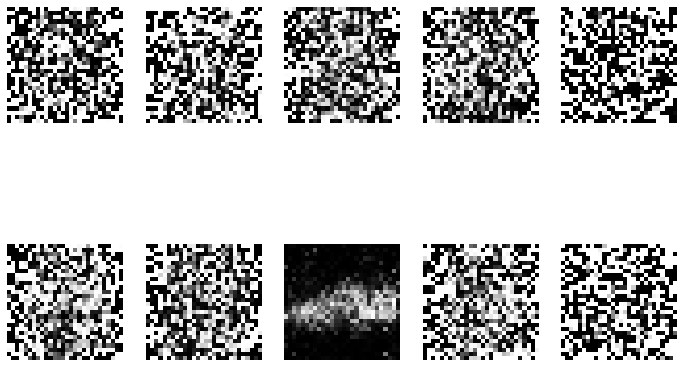

Epoch: 2001  |  Discr loss: 0.4894  |  Discr acc: 76.56  |  Gen loss: 0.1411
Epoch: 2002  |  Discr loss: 0.4457  |  Discr acc: 79.30  |  Gen loss: 0.2653
Epoch: 2003  |  Discr loss: 0.4503  |  Discr acc: 80.47  |  Gen loss: 0.2701
Epoch: 2004  |  Discr loss: 0.4729  |  Discr acc: 76.17  |  Gen loss: 0.2213
Epoch: 2005  |  Discr loss: 0.4363  |  Discr acc: 78.12  |  Gen loss: 0.2062
Epoch: 2006  |  Discr loss: 0.4599  |  Discr acc: 76.56  |  Gen loss: 0.2839
Epoch: 2007  |  Discr loss: 0.5274  |  Discr acc: 73.44  |  Gen loss: 0.2245
Epoch: 2008  |  Discr loss: 0.5871  |  Discr acc: 67.58  |  Gen loss: 0.2384
Epoch: 2009  |  Discr loss: 0.4945  |  Discr acc: 76.56  |  Gen loss: 0.2298
Epoch: 2010  |  Discr loss: 0.4788  |  Discr acc: 77.73  |  Gen loss: 0.2418
Epoch: 2011  |  Discr loss: 0.5145  |  Discr acc: 74.61  |  Gen loss: 0.2249
Epoch: 2012  |  Discr loss: 0.4924  |  Discr acc: 77.73  |  Gen loss: 0.3647
Epoch: 2013  |  Discr loss: 0.5549  |  Discr acc: 70.31  |  Gen loss: 0.2253

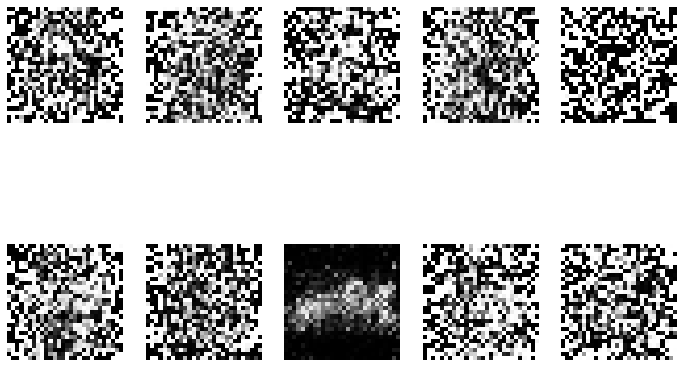

Epoch: 2251  |  Discr loss: 0.5089  |  Discr acc: 71.88  |  Gen loss: 0.1696
Epoch: 2252  |  Discr loss: 0.4470  |  Discr acc: 78.91  |  Gen loss: 0.1892
Epoch: 2253  |  Discr loss: 0.4455  |  Discr acc: 77.73  |  Gen loss: 0.1352
Epoch: 2254  |  Discr loss: 0.4809  |  Discr acc: 75.39  |  Gen loss: 0.2291
Epoch: 2255  |  Discr loss: 0.4715  |  Discr acc: 73.44  |  Gen loss: 0.1524
Epoch: 2256  |  Discr loss: 0.4183  |  Discr acc: 80.86  |  Gen loss: 0.1729
Epoch: 2257  |  Discr loss: 0.4566  |  Discr acc: 76.56  |  Gen loss: 0.2238
Epoch: 2258  |  Discr loss: 0.5150  |  Discr acc: 75.00  |  Gen loss: 0.2092
Epoch: 2259  |  Discr loss: 0.5022  |  Discr acc: 76.17  |  Gen loss: 0.1593
Epoch: 2260  |  Discr loss: 0.4867  |  Discr acc: 74.61  |  Gen loss: 0.2695
Epoch: 2261  |  Discr loss: 0.6301  |  Discr acc: 64.06  |  Gen loss: 0.1317
Epoch: 2262  |  Discr loss: 0.4741  |  Discr acc: 75.78  |  Gen loss: 0.2282
Epoch: 2263  |  Discr loss: 0.5462  |  Discr acc: 71.09  |  Gen loss: 0.2090

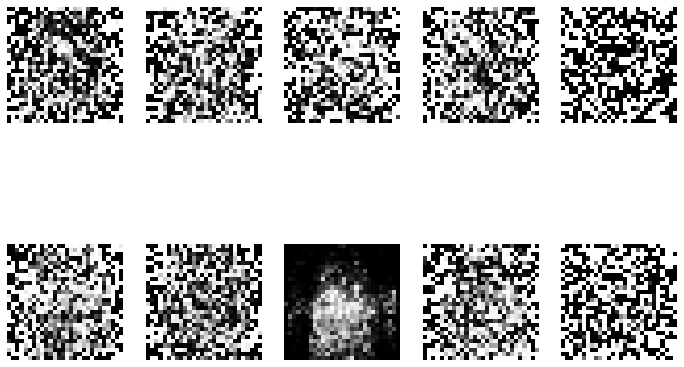

Epoch: 2501  |  Discr loss: 0.5430  |  Discr acc: 70.31  |  Gen loss: 0.2204
Epoch: 2502  |  Discr loss: 0.4630  |  Discr acc: 77.34  |  Gen loss: 0.3262
Epoch: 2503  |  Discr loss: 0.4442  |  Discr acc: 80.47  |  Gen loss: 0.1857
Epoch: 2504  |  Discr loss: 0.4991  |  Discr acc: 76.17  |  Gen loss: 0.2534
Epoch: 2505  |  Discr loss: 0.4280  |  Discr acc: 80.08  |  Gen loss: 0.2511
Epoch: 2506  |  Discr loss: 0.4402  |  Discr acc: 79.30  |  Gen loss: 0.3128
Epoch: 2507  |  Discr loss: 0.4103  |  Discr acc: 82.42  |  Gen loss: 0.3602
Epoch: 2508  |  Discr loss: 0.4447  |  Discr acc: 77.34  |  Gen loss: 0.3692
Epoch: 2509  |  Discr loss: 0.4147  |  Discr acc: 82.03  |  Gen loss: 0.2728
Epoch: 2510  |  Discr loss: 0.4582  |  Discr acc: 77.73  |  Gen loss: 0.3220
Epoch: 2511  |  Discr loss: 0.3948  |  Discr acc: 85.16  |  Gen loss: 0.3551
Epoch: 2512  |  Discr loss: 0.5151  |  Discr acc: 75.39  |  Gen loss: 0.3957
Epoch: 2513  |  Discr loss: 0.4511  |  Discr acc: 79.30  |  Gen loss: 0.3206

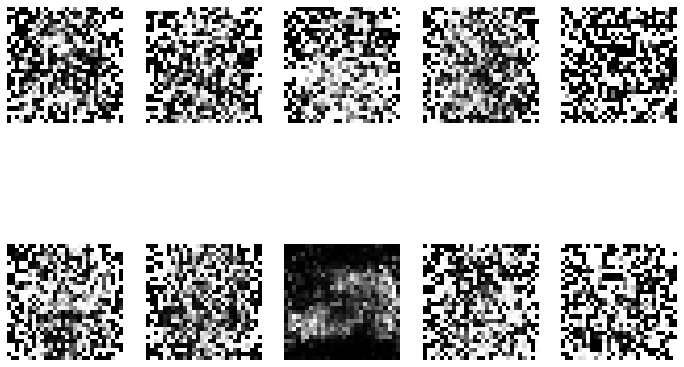

Epoch: 2751  |  Discr loss: 0.3842  |  Discr acc: 83.20  |  Gen loss: 0.2448
Epoch: 2752  |  Discr loss: 0.3099  |  Discr acc: 88.67  |  Gen loss: 0.2458
Epoch: 2753  |  Discr loss: 0.3321  |  Discr acc: 87.50  |  Gen loss: 0.2614
Epoch: 2754  |  Discr loss: 0.3750  |  Discr acc: 82.42  |  Gen loss: 0.2950
Epoch: 2755  |  Discr loss: 0.4876  |  Discr acc: 74.61  |  Gen loss: 0.3353
Epoch: 2756  |  Discr loss: 0.4438  |  Discr acc: 81.25  |  Gen loss: 0.3235
Epoch: 2757  |  Discr loss: 0.4443  |  Discr acc: 80.47  |  Gen loss: 0.2784
Epoch: 2758  |  Discr loss: 0.4418  |  Discr acc: 80.86  |  Gen loss: 0.3122
Epoch: 2759  |  Discr loss: 0.5778  |  Discr acc: 70.31  |  Gen loss: 0.3302
Epoch: 2760  |  Discr loss: 0.5364  |  Discr acc: 75.00  |  Gen loss: 0.2784
Epoch: 2761  |  Discr loss: 0.5338  |  Discr acc: 74.61  |  Gen loss: 0.3856
Epoch: 2762  |  Discr loss: 0.5807  |  Discr acc: 70.31  |  Gen loss: 0.3552
Epoch: 2763  |  Discr loss: 0.5530  |  Discr acc: 70.31  |  Gen loss: 0.2711

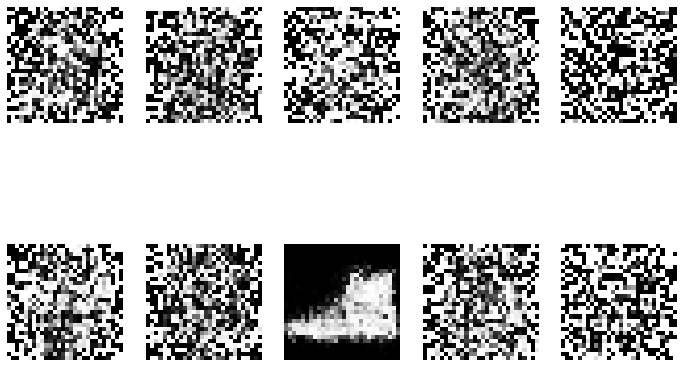

Epoch: 3001  |  Discr loss: 0.4705  |  Discr acc: 77.73  |  Gen loss: 0.3715
Epoch: 3002  |  Discr loss: 0.5682  |  Discr acc: 69.53  |  Gen loss: 0.2897
Epoch: 3003  |  Discr loss: 0.5773  |  Discr acc: 69.92  |  Gen loss: 0.2443
Epoch: 3004  |  Discr loss: 0.5810  |  Discr acc: 68.75  |  Gen loss: 0.1973
Epoch: 3005  |  Discr loss: 0.6381  |  Discr acc: 65.23  |  Gen loss: 0.2099
Epoch: 3006  |  Discr loss: 0.6088  |  Discr acc: 67.19  |  Gen loss: 0.1772
Epoch: 3007  |  Discr loss: 0.5170  |  Discr acc: 73.05  |  Gen loss: 0.1663
Epoch: 3008  |  Discr loss: 0.5351  |  Discr acc: 69.53  |  Gen loss: 0.2577
Epoch: 3009  |  Discr loss: 0.5164  |  Discr acc: 71.88  |  Gen loss: 0.1840
Epoch: 3010  |  Discr loss: 0.4965  |  Discr acc: 74.22  |  Gen loss: 0.1544
Epoch: 3011  |  Discr loss: 0.4745  |  Discr acc: 76.56  |  Gen loss: 0.1410
Epoch: 3012  |  Discr loss: 0.5294  |  Discr acc: 70.31  |  Gen loss: 0.2106
Epoch: 3013  |  Discr loss: 0.4575  |  Discr acc: 76.17  |  Gen loss: 0.1624

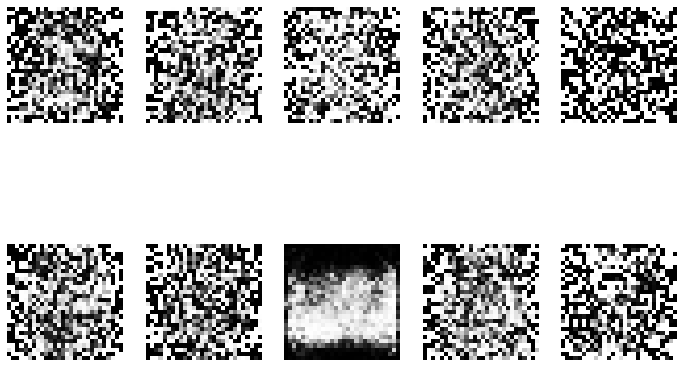

Epoch: 3251  |  Discr loss: 0.3485  |  Discr acc: 88.28  |  Gen loss: 0.1635
Epoch: 3252  |  Discr loss: 0.3987  |  Discr acc: 81.64  |  Gen loss: 0.2511
Epoch: 3253  |  Discr loss: 0.3610  |  Discr acc: 84.38  |  Gen loss: 0.2788
Epoch: 3254  |  Discr loss: 0.4417  |  Discr acc: 79.30  |  Gen loss: 0.1341
Epoch: 3255  |  Discr loss: 0.3179  |  Discr acc: 86.33  |  Gen loss: 0.2353
Epoch: 3256  |  Discr loss: 0.3818  |  Discr acc: 81.64  |  Gen loss: 0.1376
Epoch: 3257  |  Discr loss: 0.3805  |  Discr acc: 82.81  |  Gen loss: 0.1440
Epoch: 3258  |  Discr loss: 0.4512  |  Discr acc: 78.91  |  Gen loss: 0.1566
Epoch: 3259  |  Discr loss: 0.4731  |  Discr acc: 77.34  |  Gen loss: 0.2847
Epoch: 3260  |  Discr loss: 0.4672  |  Discr acc: 78.12  |  Gen loss: 0.1949
Epoch: 3261  |  Discr loss: 0.4628  |  Discr acc: 76.95  |  Gen loss: 0.1456
Epoch: 3262  |  Discr loss: 0.5233  |  Discr acc: 72.66  |  Gen loss: 0.1700
Epoch: 3263  |  Discr loss: 0.5624  |  Discr acc: 71.09  |  Gen loss: 0.2109

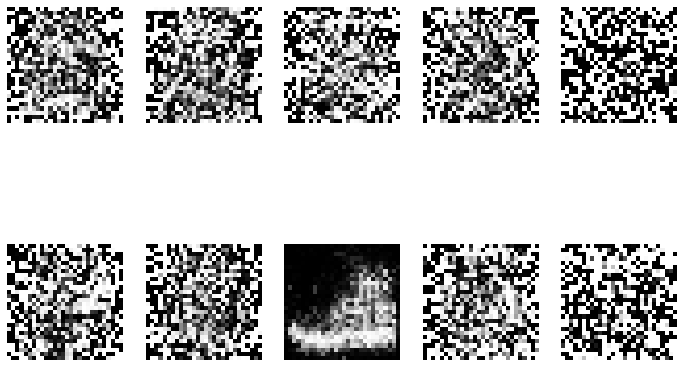

Epoch: 3501  |  Discr loss: 0.5772  |  Discr acc: 71.09  |  Gen loss: 0.2784
Epoch: 3502  |  Discr loss: 0.5018  |  Discr acc: 75.39  |  Gen loss: 0.3696
Epoch: 3503  |  Discr loss: 0.4804  |  Discr acc: 78.52  |  Gen loss: 0.2870
Epoch: 3504  |  Discr loss: 0.4975  |  Discr acc: 74.61  |  Gen loss: 0.2514
Epoch: 3505  |  Discr loss: 0.5268  |  Discr acc: 74.61  |  Gen loss: 0.2512
Epoch: 3506  |  Discr loss: 0.5252  |  Discr acc: 72.27  |  Gen loss: 0.2581
Epoch: 3507  |  Discr loss: 0.4830  |  Discr acc: 75.39  |  Gen loss: 0.2743
Epoch: 3508  |  Discr loss: 0.5036  |  Discr acc: 74.22  |  Gen loss: 0.2924
Epoch: 3509  |  Discr loss: 0.5227  |  Discr acc: 71.48  |  Gen loss: 0.1701
Epoch: 3510  |  Discr loss: 0.5293  |  Discr acc: 75.78  |  Gen loss: 0.3760
Epoch: 3511  |  Discr loss: 0.6602  |  Discr acc: 66.02  |  Gen loss: 0.3572
Epoch: 3512  |  Discr loss: 0.5153  |  Discr acc: 71.88  |  Gen loss: 0.3005
Epoch: 3513  |  Discr loss: 0.5565  |  Discr acc: 69.14  |  Gen loss: 0.2725

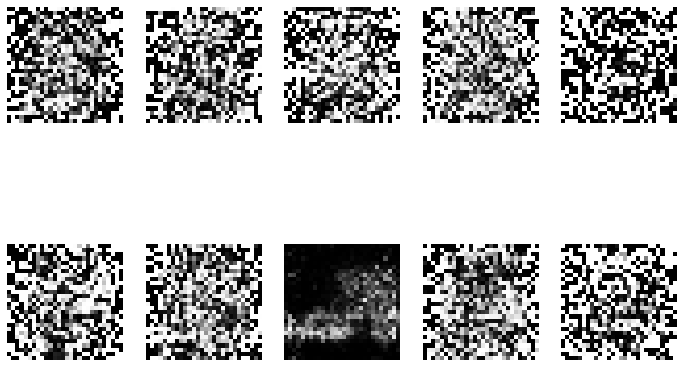

Epoch: 3751  |  Discr loss: 0.5150  |  Discr acc: 71.48  |  Gen loss: 0.1378
Epoch: 3752  |  Discr loss: 0.3805  |  Discr acc: 82.81  |  Gen loss: 0.1821
Epoch: 3753  |  Discr loss: 0.4272  |  Discr acc: 80.47  |  Gen loss: 0.1882
Epoch: 3754  |  Discr loss: 0.3783  |  Discr acc: 83.98  |  Gen loss: 0.1549
Epoch: 3755  |  Discr loss: 0.4784  |  Discr acc: 78.12  |  Gen loss: 0.2197
Epoch: 3756  |  Discr loss: 0.3673  |  Discr acc: 82.81  |  Gen loss: 0.2137
Epoch: 3757  |  Discr loss: 0.4067  |  Discr acc: 81.25  |  Gen loss: 0.1594
Epoch: 3758  |  Discr loss: 0.5167  |  Discr acc: 76.95  |  Gen loss: 0.2084
Epoch: 3759  |  Discr loss: 0.4726  |  Discr acc: 75.78  |  Gen loss: 0.1050
Epoch: 3760  |  Discr loss: 0.4725  |  Discr acc: 75.00  |  Gen loss: 0.0913
Epoch: 3761  |  Discr loss: 0.4043  |  Discr acc: 80.08  |  Gen loss: 0.1799
Epoch: 3762  |  Discr loss: 0.3659  |  Discr acc: 85.16  |  Gen loss: 0.2316
Epoch: 3763  |  Discr loss: 0.3866  |  Discr acc: 83.59  |  Gen loss: 0.1364

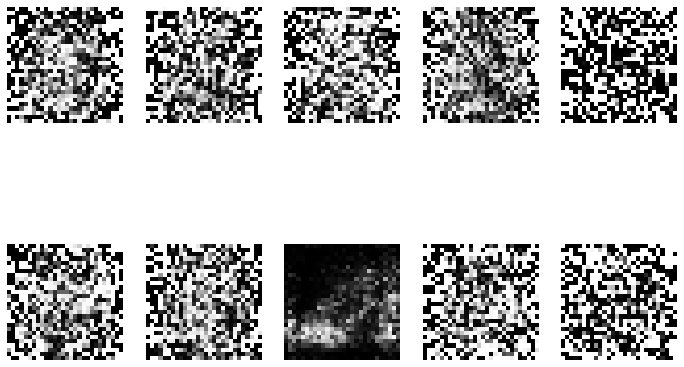

Epoch: 4001  |  Discr loss: 0.3539  |  Discr acc: 84.77  |  Gen loss: 0.1437
Epoch: 4002  |  Discr loss: 0.3774  |  Discr acc: 83.59  |  Gen loss: 0.1941
Epoch: 4003  |  Discr loss: 0.4218  |  Discr acc: 80.86  |  Gen loss: 0.2290
Epoch: 4004  |  Discr loss: 0.3833  |  Discr acc: 83.98  |  Gen loss: 0.1937
Epoch: 4005  |  Discr loss: 0.4269  |  Discr acc: 80.08  |  Gen loss: 0.1791
Epoch: 4006  |  Discr loss: 0.3849  |  Discr acc: 82.03  |  Gen loss: 0.1447
Epoch: 4007  |  Discr loss: 0.4556  |  Discr acc: 78.52  |  Gen loss: 0.1532
Epoch: 4008  |  Discr loss: 0.4154  |  Discr acc: 81.64  |  Gen loss: 0.1133
Epoch: 4009  |  Discr loss: 0.3485  |  Discr acc: 85.16  |  Gen loss: 0.1677
Epoch: 4010  |  Discr loss: 0.3122  |  Discr acc: 87.50  |  Gen loss: 0.1996
Epoch: 4011  |  Discr loss: 0.4012  |  Discr acc: 82.03  |  Gen loss: 0.1174
Epoch: 4012  |  Discr loss: 0.3708  |  Discr acc: 83.98  |  Gen loss: 0.1757
Epoch: 4013  |  Discr loss: 0.3671  |  Discr acc: 82.81  |  Gen loss: 0.2473

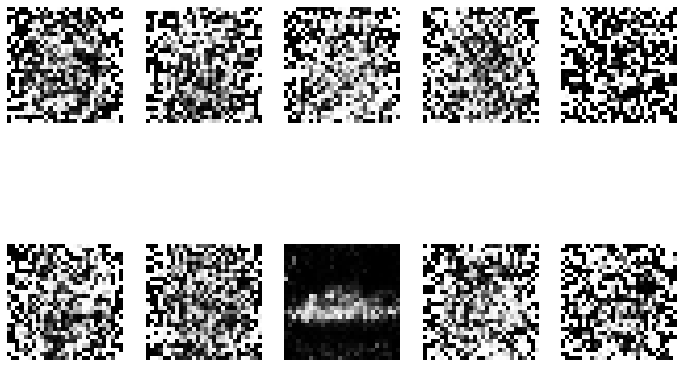

Epoch: 4251  |  Discr loss: 0.4399  |  Discr acc: 78.52  |  Gen loss: 0.1471
Epoch: 4252  |  Discr loss: 0.4431  |  Discr acc: 78.91  |  Gen loss: 0.1243
Epoch: 4253  |  Discr loss: 0.3742  |  Discr acc: 83.59  |  Gen loss: 0.2220
Epoch: 4254  |  Discr loss: 0.4648  |  Discr acc: 75.39  |  Gen loss: 0.2135
Epoch: 4255  |  Discr loss: 0.4601  |  Discr acc: 76.95  |  Gen loss: 0.1712
Epoch: 4256  |  Discr loss: 0.3795  |  Discr acc: 82.42  |  Gen loss: 0.2091
Epoch: 4257  |  Discr loss: 0.4066  |  Discr acc: 82.42  |  Gen loss: 0.2843
Epoch: 4258  |  Discr loss: 0.4800  |  Discr acc: 74.61  |  Gen loss: 0.1538
Epoch: 4259  |  Discr loss: 0.3699  |  Discr acc: 85.16  |  Gen loss: 0.2496
Epoch: 4260  |  Discr loss: 0.4418  |  Discr acc: 81.25  |  Gen loss: 0.2924
Epoch: 4261  |  Discr loss: 0.4079  |  Discr acc: 80.47  |  Gen loss: 0.1764
Epoch: 4262  |  Discr loss: 0.4527  |  Discr acc: 78.52  |  Gen loss: 0.2280
Epoch: 4263  |  Discr loss: 0.4187  |  Discr acc: 79.69  |  Gen loss: 0.2192

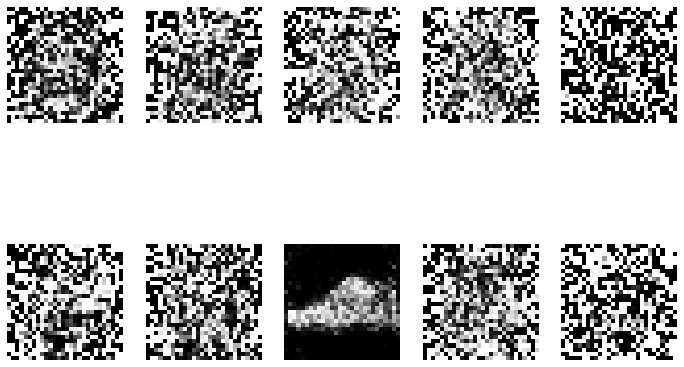

Epoch: 4501  |  Discr loss: 0.3117  |  Discr acc: 88.67  |  Gen loss: 0.1960
Epoch: 4502  |  Discr loss: 0.3096  |  Discr acc: 87.89  |  Gen loss: 0.2668
Epoch: 4503  |  Discr loss: 0.2752  |  Discr acc: 88.67  |  Gen loss: 0.2180
Epoch: 4504  |  Discr loss: 0.2796  |  Discr acc: 89.84  |  Gen loss: 0.2951
Epoch: 4505  |  Discr loss: 0.3949  |  Discr acc: 79.69  |  Gen loss: 0.1619
Epoch: 4506  |  Discr loss: 0.2893  |  Discr acc: 86.33  |  Gen loss: 0.3280
Epoch: 4507  |  Discr loss: 0.4019  |  Discr acc: 81.64  |  Gen loss: 0.1273
Epoch: 4508  |  Discr loss: 0.3017  |  Discr acc: 89.06  |  Gen loss: 0.2425
Epoch: 4509  |  Discr loss: 0.2984  |  Discr acc: 89.84  |  Gen loss: 0.1953
Epoch: 4510  |  Discr loss: 0.3481  |  Discr acc: 87.50  |  Gen loss: 0.1566
Epoch: 4511  |  Discr loss: 0.3304  |  Discr acc: 84.77  |  Gen loss: 0.2420
Epoch: 4512  |  Discr loss: 0.3205  |  Discr acc: 86.72  |  Gen loss: 0.2080
Epoch: 4513  |  Discr loss: 0.4583  |  Discr acc: 75.78  |  Gen loss: 0.1607

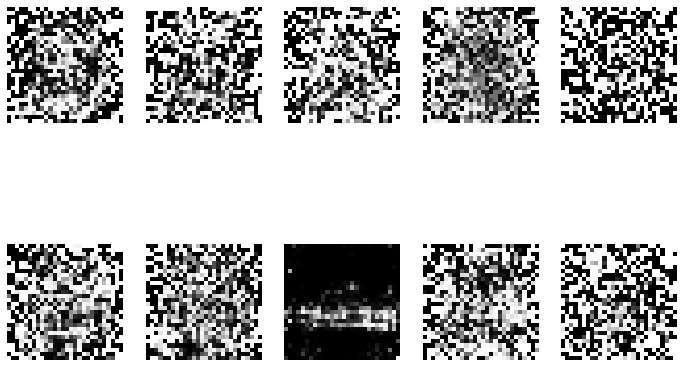

Epoch: 4751  |  Discr loss: 0.3275  |  Discr acc: 86.33  |  Gen loss: 0.1672
Epoch: 4752  |  Discr loss: 0.3517  |  Discr acc: 85.55  |  Gen loss: 0.1609
Epoch: 4753  |  Discr loss: 0.3608  |  Discr acc: 83.20  |  Gen loss: 0.1674
Epoch: 4754  |  Discr loss: 0.2948  |  Discr acc: 87.50  |  Gen loss: 0.2375
Epoch: 4755  |  Discr loss: 0.4168  |  Discr acc: 82.03  |  Gen loss: 0.2809
Epoch: 4756  |  Discr loss: 0.3447  |  Discr acc: 85.16  |  Gen loss: 0.1729
Epoch: 4757  |  Discr loss: 0.3420  |  Discr acc: 85.55  |  Gen loss: 0.2153
Epoch: 4758  |  Discr loss: 0.4018  |  Discr acc: 82.03  |  Gen loss: 0.1636
Epoch: 4759  |  Discr loss: 0.3494  |  Discr acc: 87.11  |  Gen loss: 0.2802
Epoch: 4760  |  Discr loss: 0.3893  |  Discr acc: 83.59  |  Gen loss: 0.1576
Epoch: 4761  |  Discr loss: 0.5119  |  Discr acc: 73.44  |  Gen loss: 0.1424
Epoch: 4762  |  Discr loss: 0.4141  |  Discr acc: 78.52  |  Gen loss: 0.1994
Epoch: 4763  |  Discr loss: 0.4271  |  Discr acc: 79.69  |  Gen loss: 0.1771

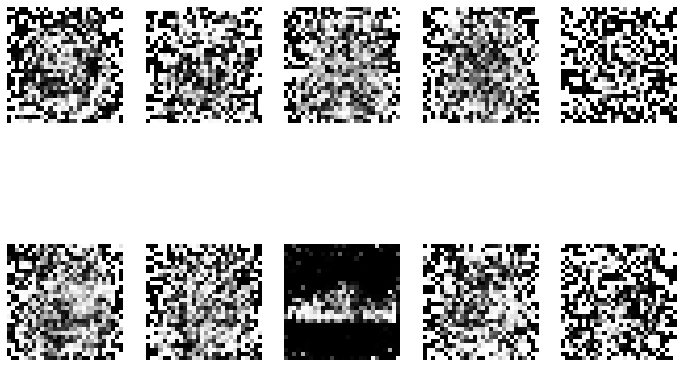

Epoch: 5001  |  Discr loss: 0.4891  |  Discr acc: 75.78  |  Gen loss: 0.1617
Epoch: 5002  |  Discr loss: 0.4015  |  Discr acc: 82.03  |  Gen loss: 0.1767
Epoch: 5003  |  Discr loss: 0.5044  |  Discr acc: 78.91  |  Gen loss: 0.1670
Epoch: 5004  |  Discr loss: 0.4268  |  Discr acc: 80.08  |  Gen loss: 0.1391
Epoch: 5005  |  Discr loss: 0.3757  |  Discr acc: 83.98  |  Gen loss: 0.2163
Epoch: 5006  |  Discr loss: 0.4527  |  Discr acc: 77.34  |  Gen loss: 0.1154
Epoch: 5007  |  Discr loss: 0.3711  |  Discr acc: 83.20  |  Gen loss: 0.1945
Epoch: 5008  |  Discr loss: 0.4545  |  Discr acc: 78.12  |  Gen loss: 0.2657
Epoch: 5009  |  Discr loss: 0.4529  |  Discr acc: 78.12  |  Gen loss: 0.0994
Epoch: 5010  |  Discr loss: 0.3861  |  Discr acc: 82.81  |  Gen loss: 0.2162
Epoch: 5011  |  Discr loss: 0.4006  |  Discr acc: 79.69  |  Gen loss: 0.1259
Epoch: 5012  |  Discr loss: 0.4093  |  Discr acc: 80.08  |  Gen loss: 0.0890
Epoch: 5013  |  Discr loss: 0.3687  |  Discr acc: 83.20  |  Gen loss: 0.1333

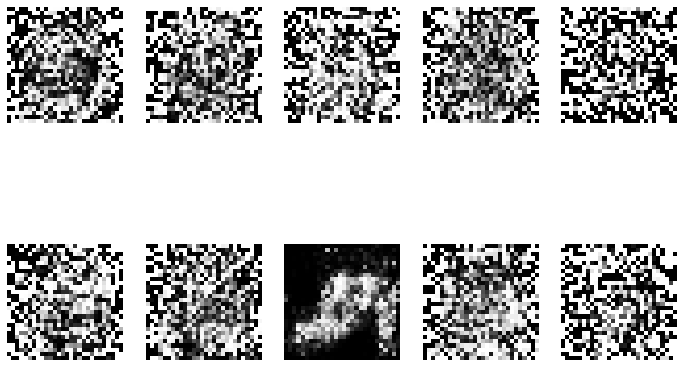

Epoch: 5251  |  Discr loss: 0.4406  |  Discr acc: 80.08  |  Gen loss: 0.1421
Epoch: 5252  |  Discr loss: 0.4538  |  Discr acc: 77.34  |  Gen loss: 0.1885
Epoch: 5253  |  Discr loss: 0.4252  |  Discr acc: 81.25  |  Gen loss: 0.1813
Epoch: 5254  |  Discr loss: 0.4265  |  Discr acc: 79.69  |  Gen loss: 0.1339
Epoch: 5255  |  Discr loss: 0.4027  |  Discr acc: 83.59  |  Gen loss: 0.2355
Epoch: 5256  |  Discr loss: 0.4237  |  Discr acc: 82.03  |  Gen loss: 0.2026
Epoch: 5257  |  Discr loss: 0.4041  |  Discr acc: 82.03  |  Gen loss: 0.1412
Epoch: 5258  |  Discr loss: 0.4130  |  Discr acc: 81.25  |  Gen loss: 0.1531
Epoch: 5259  |  Discr loss: 0.4013  |  Discr acc: 81.64  |  Gen loss: 0.2091
Epoch: 5260  |  Discr loss: 0.3968  |  Discr acc: 81.25  |  Gen loss: 0.1168
Epoch: 5261  |  Discr loss: 0.3845  |  Discr acc: 84.38  |  Gen loss: 0.1707
Epoch: 5262  |  Discr loss: 0.3020  |  Discr acc: 89.84  |  Gen loss: 0.1482
Epoch: 5263  |  Discr loss: 0.3467  |  Discr acc: 85.16  |  Gen loss: 0.1820

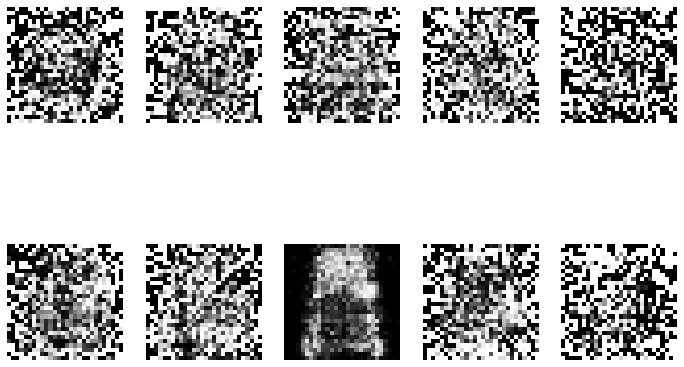

Epoch: 5501  |  Discr loss: 0.3737  |  Discr acc: 84.38  |  Gen loss: 0.1607
Epoch: 5502  |  Discr loss: 0.4834  |  Discr acc: 76.95  |  Gen loss: 0.2746
Epoch: 5503  |  Discr loss: 0.4422  |  Discr acc: 80.86  |  Gen loss: 0.1277
Epoch: 5504  |  Discr loss: 0.4025  |  Discr acc: 82.42  |  Gen loss: 0.1756
Epoch: 5505  |  Discr loss: 0.4291  |  Discr acc: 80.08  |  Gen loss: 0.1618
Epoch: 5506  |  Discr loss: 0.3895  |  Discr acc: 81.64  |  Gen loss: 0.2236
Epoch: 5507  |  Discr loss: 0.3863  |  Discr acc: 82.42  |  Gen loss: 0.2125
Epoch: 5508  |  Discr loss: 0.3631  |  Discr acc: 83.98  |  Gen loss: 0.1465
Epoch: 5509  |  Discr loss: 0.3569  |  Discr acc: 82.42  |  Gen loss: 0.1970
Epoch: 5510  |  Discr loss: 0.3971  |  Discr acc: 79.69  |  Gen loss: 0.1123
Epoch: 5511  |  Discr loss: 0.4109  |  Discr acc: 80.08  |  Gen loss: 0.2406
Epoch: 5512  |  Discr loss: 0.4242  |  Discr acc: 79.69  |  Gen loss: 0.2182
Epoch: 5513  |  Discr loss: 0.4157  |  Discr acc: 79.69  |  Gen loss: 0.2391

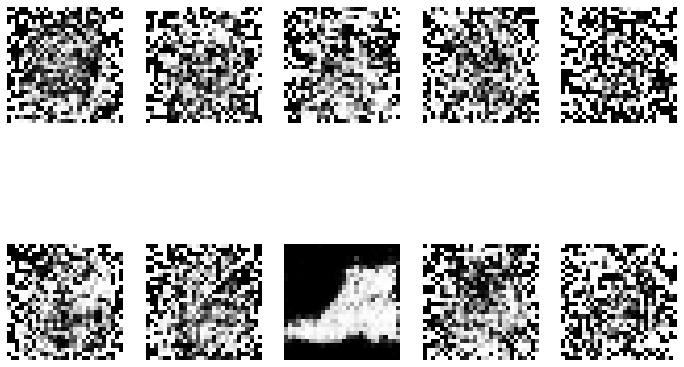

Epoch: 5751  |  Discr loss: 0.4354  |  Discr acc: 80.47  |  Gen loss: 0.2251
Epoch: 5752  |  Discr loss: 0.4692  |  Discr acc: 78.52  |  Gen loss: 0.1296
Epoch: 5753  |  Discr loss: 0.4113  |  Discr acc: 80.47  |  Gen loss: 0.1368
Epoch: 5754  |  Discr loss: 0.4097  |  Discr acc: 81.25  |  Gen loss: 0.1488
Epoch: 5755  |  Discr loss: 0.3890  |  Discr acc: 81.25  |  Gen loss: 0.1506
Epoch: 5756  |  Discr loss: 0.4010  |  Discr acc: 81.64  |  Gen loss: 0.1434
Epoch: 5757  |  Discr loss: 0.4022  |  Discr acc: 81.25  |  Gen loss: 0.1430
Epoch: 5758  |  Discr loss: 0.3803  |  Discr acc: 83.20  |  Gen loss: 0.1692
Epoch: 5759  |  Discr loss: 0.4480  |  Discr acc: 78.52  |  Gen loss: 0.1728
Epoch: 5760  |  Discr loss: 0.4935  |  Discr acc: 74.22  |  Gen loss: 0.1355
Epoch: 5761  |  Discr loss: 0.4324  |  Discr acc: 80.86  |  Gen loss: 0.0939
Epoch: 5762  |  Discr loss: 0.4210  |  Discr acc: 80.47  |  Gen loss: 0.1506
Epoch: 5763  |  Discr loss: 0.4203  |  Discr acc: 80.47  |  Gen loss: 0.0775

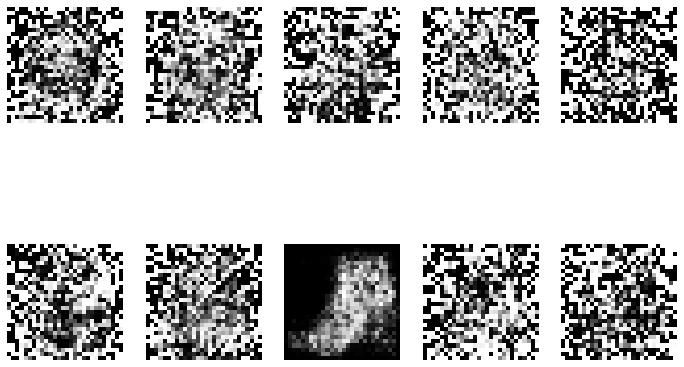

Epoch: 6001  |  Discr loss: 0.3414  |  Discr acc: 86.33  |  Gen loss: 0.2591
Epoch: 6002  |  Discr loss: 0.3511  |  Discr acc: 84.38  |  Gen loss: 0.1675
Epoch: 6003  |  Discr loss: 0.4085  |  Discr acc: 80.08  |  Gen loss: 0.1882
Epoch: 6004  |  Discr loss: 0.3862  |  Discr acc: 82.03  |  Gen loss: 0.2341
Epoch: 6005  |  Discr loss: 0.3674  |  Discr acc: 83.20  |  Gen loss: 0.1955
Epoch: 6006  |  Discr loss: 0.4019  |  Discr acc: 82.81  |  Gen loss: 0.1832
Epoch: 6007  |  Discr loss: 0.3825  |  Discr acc: 83.20  |  Gen loss: 0.2127
Epoch: 6008  |  Discr loss: 0.3521  |  Discr acc: 87.11  |  Gen loss: 0.1731
Epoch: 6009  |  Discr loss: 0.4158  |  Discr acc: 80.86  |  Gen loss: 0.2032
Epoch: 6010  |  Discr loss: 0.3988  |  Discr acc: 83.20  |  Gen loss: 0.2714
Epoch: 6011  |  Discr loss: 0.4327  |  Discr acc: 79.69  |  Gen loss: 0.1984
Epoch: 6012  |  Discr loss: 0.5239  |  Discr acc: 75.78  |  Gen loss: 0.2164
Epoch: 6013  |  Discr loss: 0.5288  |  Discr acc: 76.17  |  Gen loss: 0.1574

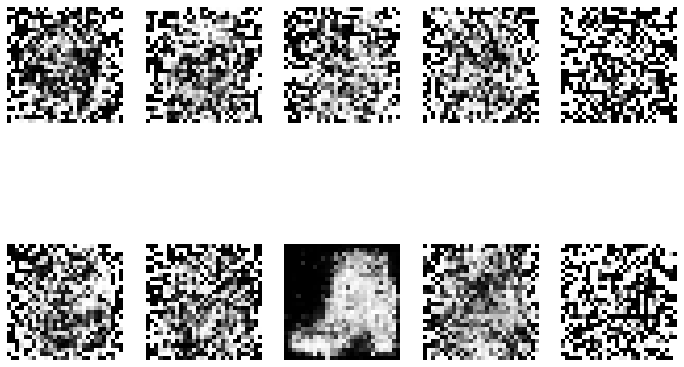

Epoch: 6251  |  Discr loss: 0.4456  |  Discr acc: 79.30  |  Gen loss: 0.1852
Epoch: 6252  |  Discr loss: 0.3559  |  Discr acc: 85.55  |  Gen loss: 0.2372
Epoch: 6253  |  Discr loss: 0.3988  |  Discr acc: 81.64  |  Gen loss: 0.1802
Epoch: 6254  |  Discr loss: 0.3569  |  Discr acc: 83.98  |  Gen loss: 0.1886
Epoch: 6255  |  Discr loss: 0.3471  |  Discr acc: 85.55  |  Gen loss: 0.1415
Epoch: 6256  |  Discr loss: 0.3731  |  Discr acc: 82.81  |  Gen loss: 0.1475
Epoch: 6257  |  Discr loss: 0.3272  |  Discr acc: 87.50  |  Gen loss: 0.1600
Epoch: 6258  |  Discr loss: 0.4222  |  Discr acc: 80.47  |  Gen loss: 0.2054
Epoch: 6259  |  Discr loss: 0.4062  |  Discr acc: 81.25  |  Gen loss: 0.1441
Epoch: 6260  |  Discr loss: 0.3518  |  Discr acc: 85.55  |  Gen loss: 0.2038
Epoch: 6261  |  Discr loss: 0.3986  |  Discr acc: 82.03  |  Gen loss: 0.1423
Epoch: 6262  |  Discr loss: 0.3973  |  Discr acc: 81.64  |  Gen loss: 0.2285
Epoch: 6263  |  Discr loss: 0.4436  |  Discr acc: 78.52  |  Gen loss: 0.1755

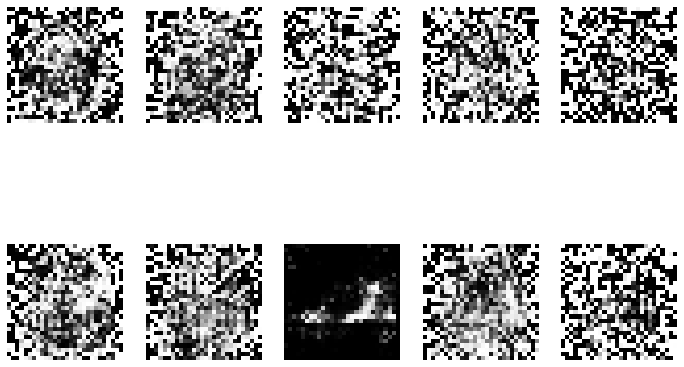

Epoch: 6501  |  Discr loss: 0.3518  |  Discr acc: 85.94  |  Gen loss: 0.1437
Epoch: 6502  |  Discr loss: 0.3846  |  Discr acc: 82.81  |  Gen loss: 0.2146
Epoch: 6503  |  Discr loss: 0.4938  |  Discr acc: 75.39  |  Gen loss: 0.2308
Epoch: 6504  |  Discr loss: 0.3892  |  Discr acc: 81.25  |  Gen loss: 0.1714
Epoch: 6505  |  Discr loss: 0.4466  |  Discr acc: 79.30  |  Gen loss: 0.1976
Epoch: 6506  |  Discr loss: 0.4256  |  Discr acc: 76.95  |  Gen loss: 0.1625
Epoch: 6507  |  Discr loss: 0.3376  |  Discr acc: 85.55  |  Gen loss: 0.1051
Epoch: 6508  |  Discr loss: 0.3801  |  Discr acc: 83.20  |  Gen loss: 0.2798
Epoch: 6509  |  Discr loss: 0.3824  |  Discr acc: 82.42  |  Gen loss: 0.1916
Epoch: 6510  |  Discr loss: 0.5034  |  Discr acc: 75.00  |  Gen loss: 0.1515
Epoch: 6511  |  Discr loss: 0.4159  |  Discr acc: 82.03  |  Gen loss: 0.1689
Epoch: 6512  |  Discr loss: 0.4036  |  Discr acc: 83.20  |  Gen loss: 0.1639
Epoch: 6513  |  Discr loss: 0.3720  |  Discr acc: 85.55  |  Gen loss: 0.1059

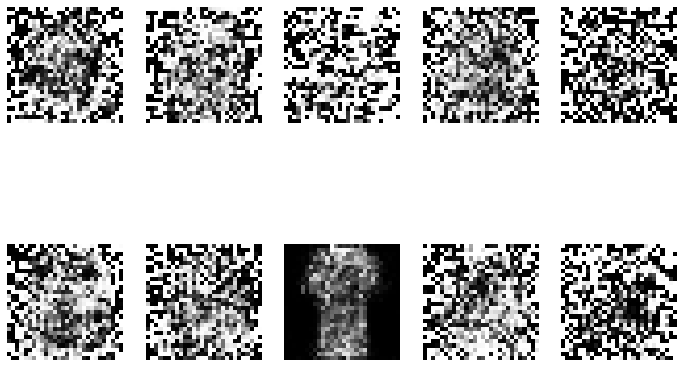

Epoch: 6751  |  Discr loss: 0.3988  |  Discr acc: 83.20  |  Gen loss: 0.1470
Epoch: 6752  |  Discr loss: 0.3281  |  Discr acc: 88.28  |  Gen loss: 0.1948
Epoch: 6753  |  Discr loss: 0.3611  |  Discr acc: 85.55  |  Gen loss: 0.1045
Epoch: 6754  |  Discr loss: 0.2792  |  Discr acc: 92.58  |  Gen loss: 0.2342
Epoch: 6755  |  Discr loss: 0.4297  |  Discr acc: 80.08  |  Gen loss: 0.1322
Epoch: 6756  |  Discr loss: 0.3995  |  Discr acc: 82.42  |  Gen loss: 0.2407
Epoch: 6757  |  Discr loss: 0.3975  |  Discr acc: 82.42  |  Gen loss: 0.2771
Epoch: 6758  |  Discr loss: 0.3613  |  Discr acc: 83.98  |  Gen loss: 0.1453
Epoch: 6759  |  Discr loss: 0.4546  |  Discr acc: 78.52  |  Gen loss: 0.2138
Epoch: 6760  |  Discr loss: 0.3469  |  Discr acc: 85.55  |  Gen loss: 0.1547
Epoch: 6761  |  Discr loss: 0.5080  |  Discr acc: 75.78  |  Gen loss: 0.1532
Epoch: 6762  |  Discr loss: 0.4929  |  Discr acc: 75.39  |  Gen loss: 0.1238
Epoch: 6763  |  Discr loss: 0.3998  |  Discr acc: 82.81  |  Gen loss: 0.1569

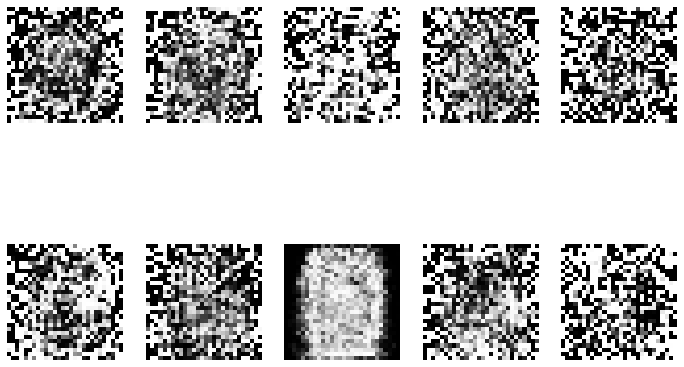

Epoch: 7001  |  Discr loss: 0.4305  |  Discr acc: 79.69  |  Gen loss: 0.1594
Epoch: 7002  |  Discr loss: 0.3766  |  Discr acc: 84.38  |  Gen loss: 0.1957
Epoch: 7003  |  Discr loss: 0.3844  |  Discr acc: 83.98  |  Gen loss: 0.1656
Epoch: 7004  |  Discr loss: 0.3422  |  Discr acc: 85.94  |  Gen loss: 0.1897
Epoch: 7005  |  Discr loss: 0.4874  |  Discr acc: 75.39  |  Gen loss: 0.2617
Epoch: 7006  |  Discr loss: 0.4531  |  Discr acc: 78.91  |  Gen loss: 0.1581
Epoch: 7007  |  Discr loss: 0.3145  |  Discr acc: 89.45  |  Gen loss: 0.1164
Epoch: 7008  |  Discr loss: 0.4381  |  Discr acc: 82.03  |  Gen loss: 0.1593
Epoch: 7009  |  Discr loss: 0.3996  |  Discr acc: 82.42  |  Gen loss: 0.1493
Epoch: 7010  |  Discr loss: 0.4470  |  Discr acc: 79.30  |  Gen loss: 0.1943
Epoch: 7011  |  Discr loss: 0.3686  |  Discr acc: 85.16  |  Gen loss: 0.2341
Epoch: 7012  |  Discr loss: 0.4972  |  Discr acc: 76.17  |  Gen loss: 0.1726
Epoch: 7013  |  Discr loss: 0.5127  |  Discr acc: 76.17  |  Gen loss: 0.1810

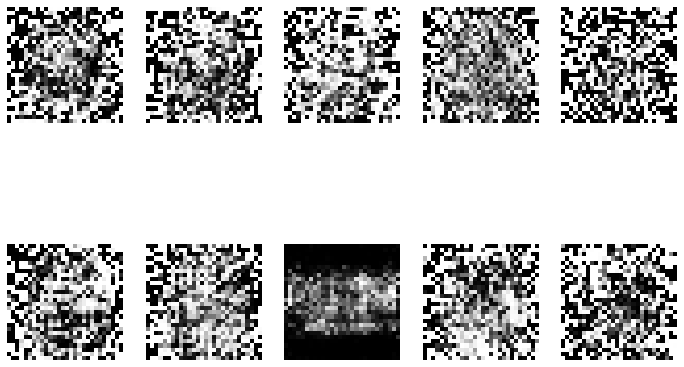

Epoch: 7251  |  Discr loss: 0.3726  |  Discr acc: 85.16  |  Gen loss: 0.1262
Epoch: 7252  |  Discr loss: 0.3165  |  Discr acc: 85.94  |  Gen loss: 0.1265
Epoch: 7253  |  Discr loss: 0.3721  |  Discr acc: 85.16  |  Gen loss: 0.1112
Epoch: 7254  |  Discr loss: 0.3224  |  Discr acc: 86.33  |  Gen loss: 0.1040
Epoch: 7255  |  Discr loss: 0.3616  |  Discr acc: 83.59  |  Gen loss: 0.1503
Epoch: 7256  |  Discr loss: 0.4056  |  Discr acc: 82.03  |  Gen loss: 0.2436
Epoch: 7257  |  Discr loss: 0.3438  |  Discr acc: 85.94  |  Gen loss: 0.2131
Epoch: 7258  |  Discr loss: 0.3497  |  Discr acc: 85.94  |  Gen loss: 0.1553
Epoch: 7259  |  Discr loss: 0.4121  |  Discr acc: 80.47  |  Gen loss: 0.1221
Epoch: 7260  |  Discr loss: 0.3587  |  Discr acc: 84.38  |  Gen loss: 0.1753
Epoch: 7261  |  Discr loss: 0.3888  |  Discr acc: 83.20  |  Gen loss: 0.1427
Epoch: 7262  |  Discr loss: 0.3924  |  Discr acc: 82.03  |  Gen loss: 0.1543
Epoch: 7263  |  Discr loss: 0.3298  |  Discr acc: 83.59  |  Gen loss: 0.2774

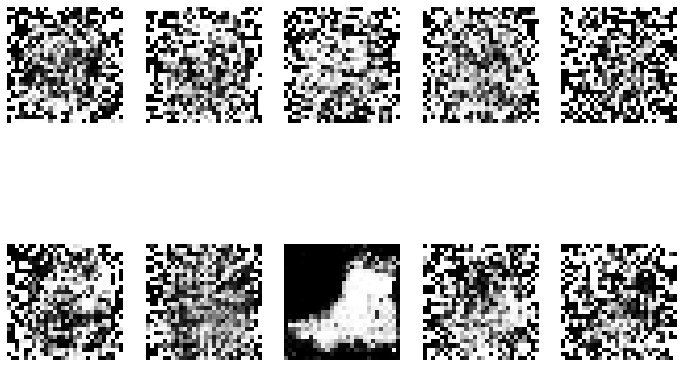

Epoch: 7501  |  Discr loss: 0.4274  |  Discr acc: 80.86  |  Gen loss: 0.2215
Epoch: 7502  |  Discr loss: 0.3833  |  Discr acc: 83.59  |  Gen loss: 0.1818
Epoch: 7503  |  Discr loss: 0.3820  |  Discr acc: 83.59  |  Gen loss: 0.1665
Epoch: 7504  |  Discr loss: 0.4270  |  Discr acc: 78.91  |  Gen loss: 0.1563
Epoch: 7505  |  Discr loss: 0.4240  |  Discr acc: 81.25  |  Gen loss: 0.1335
Epoch: 7506  |  Discr loss: 0.4533  |  Discr acc: 79.30  |  Gen loss: 0.1175
Epoch: 7507  |  Discr loss: 0.3379  |  Discr acc: 85.55  |  Gen loss: 0.2056
Epoch: 7508  |  Discr loss: 0.4452  |  Discr acc: 79.30  |  Gen loss: 0.2080
Epoch: 7509  |  Discr loss: 0.3991  |  Discr acc: 81.64  |  Gen loss: 0.1233
Epoch: 7510  |  Discr loss: 0.3698  |  Discr acc: 82.81  |  Gen loss: 0.2267
Epoch: 7511  |  Discr loss: 0.3564  |  Discr acc: 85.16  |  Gen loss: 0.2101
Epoch: 7512  |  Discr loss: 0.3994  |  Discr acc: 82.03  |  Gen loss: 0.1623
Epoch: 7513  |  Discr loss: 0.5046  |  Discr acc: 73.05  |  Gen loss: 0.1626

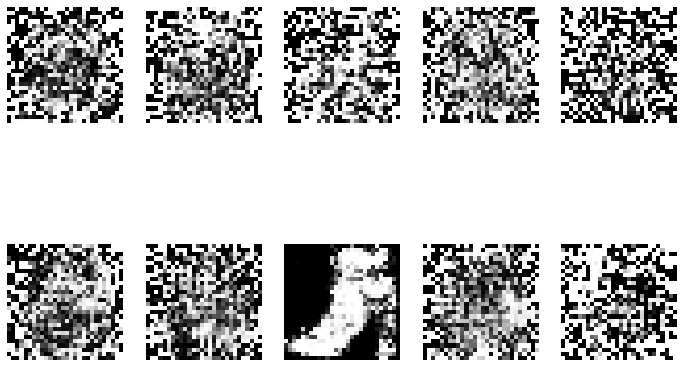

Epoch: 7751  |  Discr loss: 0.4065  |  Discr acc: 81.25  |  Gen loss: 0.1147
Epoch: 7752  |  Discr loss: 0.3498  |  Discr acc: 84.77  |  Gen loss: 0.1952
Epoch: 7753  |  Discr loss: 0.4894  |  Discr acc: 78.91  |  Gen loss: 0.1486
Epoch: 7754  |  Discr loss: 0.4661  |  Discr acc: 77.34  |  Gen loss: 0.0895
Epoch: 7755  |  Discr loss: 0.4109  |  Discr acc: 81.64  |  Gen loss: 0.2176
Epoch: 7756  |  Discr loss: 0.4714  |  Discr acc: 77.34  |  Gen loss: 0.2520
Epoch: 7757  |  Discr loss: 0.6672  |  Discr acc: 66.80  |  Gen loss: 0.1564
Epoch: 7758  |  Discr loss: 0.5142  |  Discr acc: 74.61  |  Gen loss: 0.1637
Epoch: 7759  |  Discr loss: 0.4643  |  Discr acc: 78.12  |  Gen loss: 0.1675
Epoch: 7760  |  Discr loss: 0.4608  |  Discr acc: 78.12  |  Gen loss: 0.1725
Epoch: 7761  |  Discr loss: 0.4879  |  Discr acc: 77.34  |  Gen loss: 0.0516
Epoch: 7762  |  Discr loss: 0.4250  |  Discr acc: 80.47  |  Gen loss: 0.0979
Epoch: 7763  |  Discr loss: 0.4666  |  Discr acc: 77.34  |  Gen loss: 0.1441

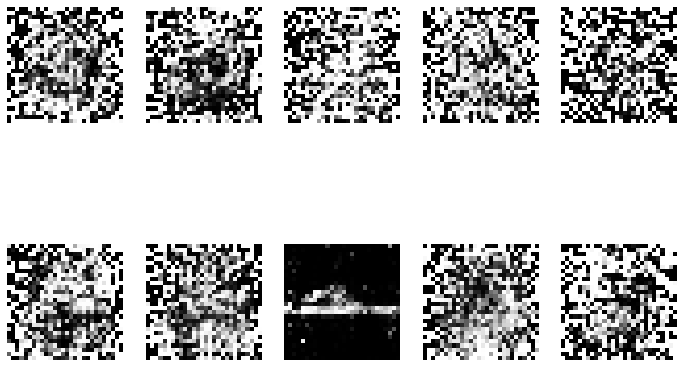

Epoch: 8001  |  Discr loss: 0.3408  |  Discr acc: 85.55  |  Gen loss: 0.2330
Epoch: 8002  |  Discr loss: 0.5065  |  Discr acc: 74.22  |  Gen loss: 0.1828
Epoch: 8003  |  Discr loss: 0.4110  |  Discr acc: 81.64  |  Gen loss: 0.2500
Epoch: 8004  |  Discr loss: 0.4408  |  Discr acc: 81.25  |  Gen loss: 0.1950
Epoch: 8005  |  Discr loss: 0.4416  |  Discr acc: 80.86  |  Gen loss: 0.1445
Epoch: 8006  |  Discr loss: 0.3997  |  Discr acc: 85.16  |  Gen loss: 0.1593
Epoch: 8007  |  Discr loss: 0.3320  |  Discr acc: 86.72  |  Gen loss: 0.2432
Epoch: 8008  |  Discr loss: 0.3307  |  Discr acc: 86.33  |  Gen loss: 0.1205
Epoch: 8009  |  Discr loss: 0.3199  |  Discr acc: 86.33  |  Gen loss: 0.1043
Epoch: 8010  |  Discr loss: 0.2799  |  Discr acc: 88.28  |  Gen loss: 0.3088
Epoch: 8011  |  Discr loss: 0.3877  |  Discr acc: 85.16  |  Gen loss: 0.2625
Epoch: 8012  |  Discr loss: 0.3226  |  Discr acc: 86.33  |  Gen loss: 0.1623
Epoch: 8013  |  Discr loss: 0.3436  |  Discr acc: 85.16  |  Gen loss: 0.1480

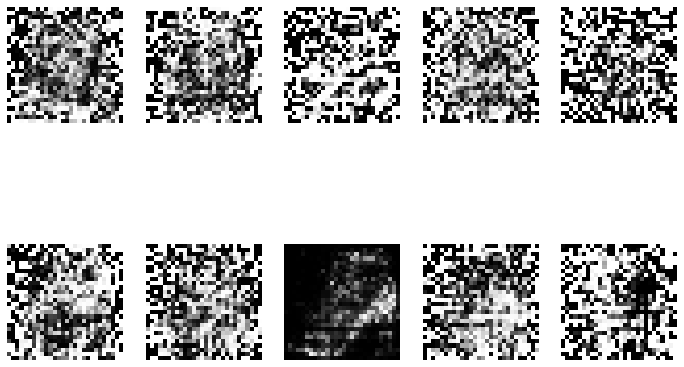

Epoch: 8251  |  Discr loss: 0.4010  |  Discr acc: 81.25  |  Gen loss: 0.1651
Epoch: 8252  |  Discr loss: 0.3767  |  Discr acc: 84.38  |  Gen loss: 0.1147
Epoch: 8253  |  Discr loss: 0.4460  |  Discr acc: 79.30  |  Gen loss: 0.2394
Epoch: 8254  |  Discr loss: 0.3358  |  Discr acc: 84.77  |  Gen loss: 0.1713
Epoch: 8255  |  Discr loss: 0.4076  |  Discr acc: 83.59  |  Gen loss: 0.1875
Epoch: 8256  |  Discr loss: 0.4194  |  Discr acc: 81.64  |  Gen loss: 0.1643
Epoch: 8257  |  Discr loss: 0.2618  |  Discr acc: 90.62  |  Gen loss: 0.3082
Epoch: 8258  |  Discr loss: 0.3305  |  Discr acc: 84.77  |  Gen loss: 0.1635
Epoch: 8259  |  Discr loss: 0.2976  |  Discr acc: 87.89  |  Gen loss: 0.2813
Epoch: 8260  |  Discr loss: 0.2663  |  Discr acc: 89.84  |  Gen loss: 0.2333
Epoch: 8261  |  Discr loss: 0.3465  |  Discr acc: 84.38  |  Gen loss: 0.2716
Epoch: 8262  |  Discr loss: 0.3391  |  Discr acc: 81.25  |  Gen loss: 0.1262
Epoch: 8263  |  Discr loss: 0.2755  |  Discr acc: 88.67  |  Gen loss: 0.2039

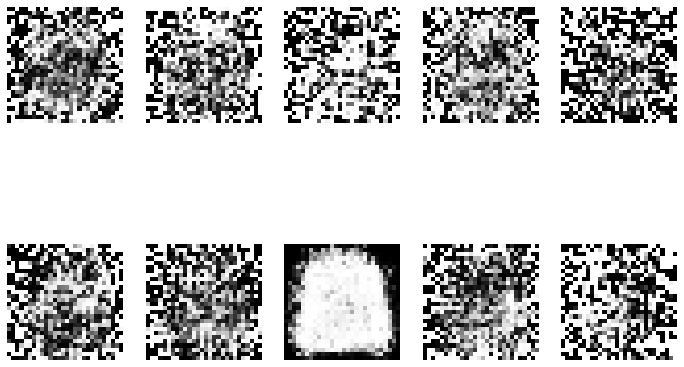

Epoch: 8501  |  Discr loss: 0.3893  |  Discr acc: 81.25  |  Gen loss: 0.1951
Epoch: 8502  |  Discr loss: 0.3943  |  Discr acc: 81.64  |  Gen loss: 0.2938
Epoch: 8503  |  Discr loss: 0.4207  |  Discr acc: 81.25  |  Gen loss: 0.2539
Epoch: 8504  |  Discr loss: 0.3610  |  Discr acc: 86.72  |  Gen loss: 0.2100
Epoch: 8505  |  Discr loss: 0.4486  |  Discr acc: 79.69  |  Gen loss: 0.1921
Epoch: 8506  |  Discr loss: 0.4750  |  Discr acc: 77.73  |  Gen loss: 0.1475
Epoch: 8507  |  Discr loss: 0.4174  |  Discr acc: 80.47  |  Gen loss: 0.1745
Epoch: 8508  |  Discr loss: 0.4534  |  Discr acc: 77.34  |  Gen loss: 0.2320
Epoch: 8509  |  Discr loss: 0.5152  |  Discr acc: 78.52  |  Gen loss: 0.2970
Epoch: 8510  |  Discr loss: 0.4135  |  Discr acc: 82.42  |  Gen loss: 0.2206
Epoch: 8511  |  Discr loss: 0.4749  |  Discr acc: 77.34  |  Gen loss: 0.1291
Epoch: 8512  |  Discr loss: 0.4458  |  Discr acc: 80.08  |  Gen loss: 0.1454
Epoch: 8513  |  Discr loss: 0.3229  |  Discr acc: 85.94  |  Gen loss: 0.1832

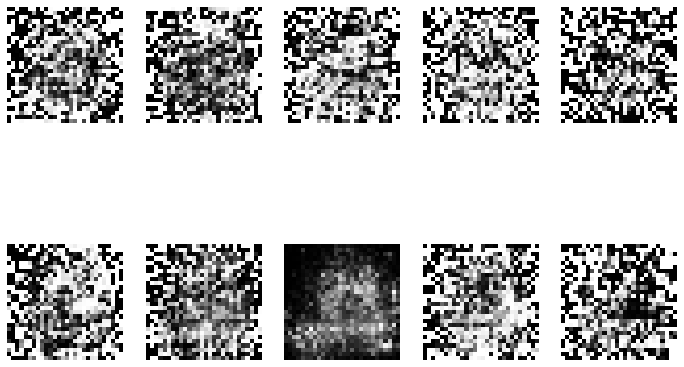

Epoch: 8751  |  Discr loss: 0.4154  |  Discr acc: 82.03  |  Gen loss: 0.1978
Epoch: 8752  |  Discr loss: 0.3668  |  Discr acc: 84.77  |  Gen loss: 0.2038
Epoch: 8753  |  Discr loss: 0.4149  |  Discr acc: 79.69  |  Gen loss: 0.1956
Epoch: 8754  |  Discr loss: 0.3577  |  Discr acc: 85.55  |  Gen loss: 0.1705
Epoch: 8755  |  Discr loss: 0.3380  |  Discr acc: 85.55  |  Gen loss: 0.1437
Epoch: 8756  |  Discr loss: 0.3371  |  Discr acc: 86.33  |  Gen loss: 0.1321
Epoch: 8757  |  Discr loss: 0.3656  |  Discr acc: 83.98  |  Gen loss: 0.1385
Epoch: 8758  |  Discr loss: 0.2682  |  Discr acc: 89.84  |  Gen loss: 0.1532
Epoch: 8759  |  Discr loss: 0.3705  |  Discr acc: 83.98  |  Gen loss: 0.1276
Epoch: 8760  |  Discr loss: 0.3137  |  Discr acc: 87.50  |  Gen loss: 0.2524
Epoch: 8761  |  Discr loss: 0.3325  |  Discr acc: 86.72  |  Gen loss: 0.2092
Epoch: 8762  |  Discr loss: 0.3410  |  Discr acc: 84.38  |  Gen loss: 0.2299
Epoch: 8763  |  Discr loss: 0.3485  |  Discr acc: 85.94  |  Gen loss: 0.1613

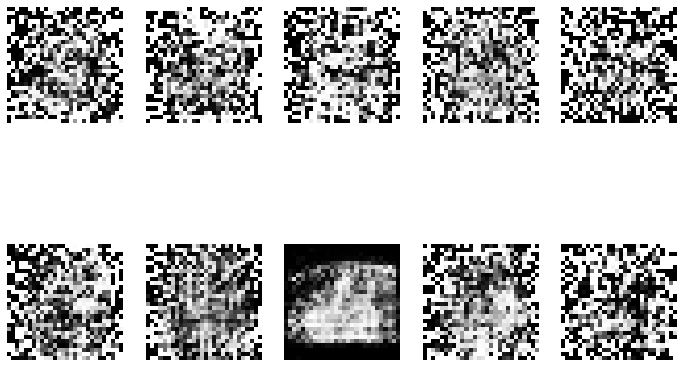

Epoch: 9001  |  Discr loss: 0.3058  |  Discr acc: 88.28  |  Gen loss: 0.2213
Epoch: 9002  |  Discr loss: 0.3106  |  Discr acc: 87.50  |  Gen loss: 0.2699
Epoch: 9003  |  Discr loss: 0.3231  |  Discr acc: 87.50  |  Gen loss: 0.2468
Epoch: 9004  |  Discr loss: 0.3662  |  Discr acc: 84.77  |  Gen loss: 0.1688
Epoch: 9005  |  Discr loss: 0.2963  |  Discr acc: 89.84  |  Gen loss: 0.1878
Epoch: 9006  |  Discr loss: 0.3666  |  Discr acc: 85.16  |  Gen loss: 0.2064
Epoch: 9007  |  Discr loss: 0.3980  |  Discr acc: 85.16  |  Gen loss: 0.1554
Epoch: 9008  |  Discr loss: 0.3259  |  Discr acc: 87.11  |  Gen loss: 0.2404
Epoch: 9009  |  Discr loss: 0.3133  |  Discr acc: 87.11  |  Gen loss: 0.0942
Epoch: 9010  |  Discr loss: 0.2855  |  Discr acc: 88.28  |  Gen loss: 0.1507
Epoch: 9011  |  Discr loss: 0.3331  |  Discr acc: 86.72  |  Gen loss: 0.1608
Epoch: 9012  |  Discr loss: 0.3580  |  Discr acc: 85.55  |  Gen loss: 0.1678
Epoch: 9013  |  Discr loss: 0.3675  |  Discr acc: 84.38  |  Gen loss: 0.2438

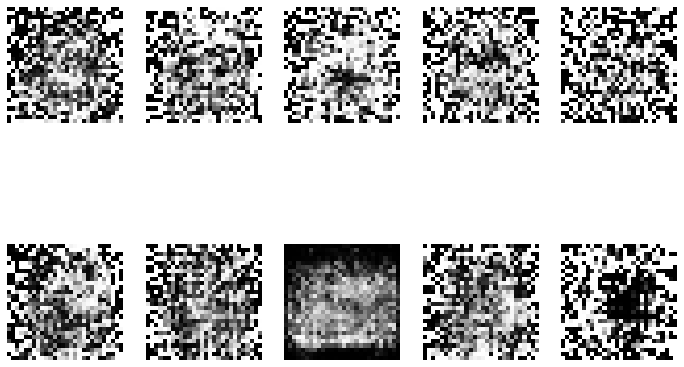

Epoch: 9251  |  Discr loss: 0.3235  |  Discr acc: 87.89  |  Gen loss: 0.1971
Epoch: 9252  |  Discr loss: 0.3334  |  Discr acc: 87.11  |  Gen loss: 0.1739
Epoch: 9253  |  Discr loss: 0.3693  |  Discr acc: 84.38  |  Gen loss: 0.1818
Epoch: 9254  |  Discr loss: 0.2990  |  Discr acc: 88.28  |  Gen loss: 0.2085
Epoch: 9255  |  Discr loss: 0.2974  |  Discr acc: 88.67  |  Gen loss: 0.1833
Epoch: 9256  |  Discr loss: 0.3135  |  Discr acc: 88.67  |  Gen loss: 0.2034
Epoch: 9257  |  Discr loss: 0.2992  |  Discr acc: 89.84  |  Gen loss: 0.2134
Epoch: 9258  |  Discr loss: 0.4278  |  Discr acc: 80.08  |  Gen loss: 0.1922
Epoch: 9259  |  Discr loss: 0.3029  |  Discr acc: 85.55  |  Gen loss: 0.2450
Epoch: 9260  |  Discr loss: 0.3535  |  Discr acc: 86.72  |  Gen loss: 0.2390
Epoch: 9261  |  Discr loss: 0.3507  |  Discr acc: 84.38  |  Gen loss: 0.1999
Epoch: 9262  |  Discr loss: 0.2889  |  Discr acc: 88.28  |  Gen loss: 0.0908
Epoch: 9263  |  Discr loss: 0.3944  |  Discr acc: 83.98  |  Gen loss: 0.1618

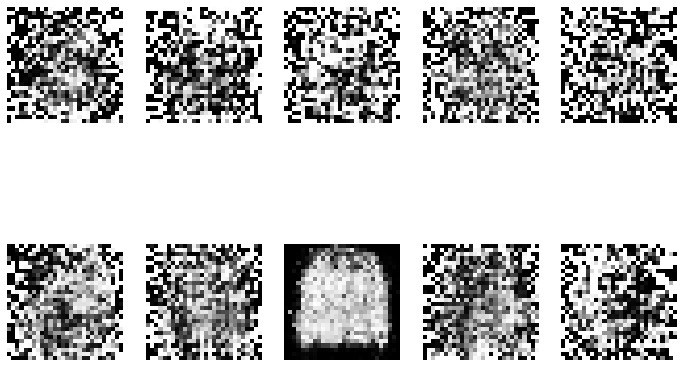

Epoch: 9501  |  Discr loss: 0.5178  |  Discr acc: 77.34  |  Gen loss: 0.1901
Epoch: 9502  |  Discr loss: 0.3539  |  Discr acc: 83.98  |  Gen loss: 0.1934
Epoch: 9503  |  Discr loss: 0.3774  |  Discr acc: 83.98  |  Gen loss: 0.2755
Epoch: 9504  |  Discr loss: 0.4131  |  Discr acc: 81.64  |  Gen loss: 0.2265
Epoch: 9505  |  Discr loss: 0.3065  |  Discr acc: 88.28  |  Gen loss: 0.1900
Epoch: 9506  |  Discr loss: 0.3735  |  Discr acc: 84.38  |  Gen loss: 0.3163
Epoch: 9507  |  Discr loss: 0.5127  |  Discr acc: 73.83  |  Gen loss: 0.2086
Epoch: 9508  |  Discr loss: 0.3372  |  Discr acc: 84.77  |  Gen loss: 0.2176
Epoch: 9509  |  Discr loss: 0.3946  |  Discr acc: 83.20  |  Gen loss: 0.1944
Epoch: 9510  |  Discr loss: 0.4952  |  Discr acc: 76.56  |  Gen loss: 0.2769
Epoch: 9511  |  Discr loss: 0.3357  |  Discr acc: 86.33  |  Gen loss: 0.1632
Epoch: 9512  |  Discr loss: 0.3678  |  Discr acc: 85.16  |  Gen loss: 0.0890
Epoch: 9513  |  Discr loss: 0.3204  |  Discr acc: 86.72  |  Gen loss: 0.1674

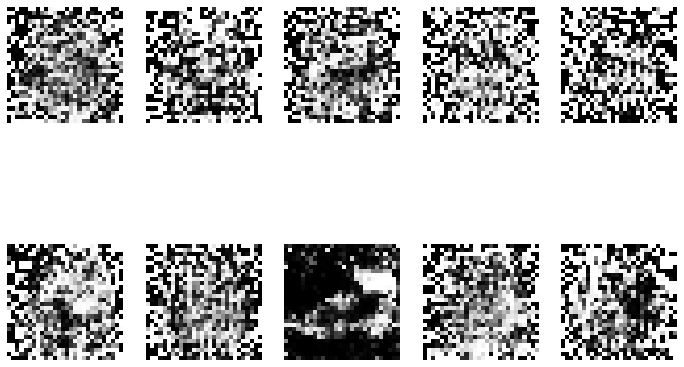

Epoch: 9751  |  Discr loss: 0.3875  |  Discr acc: 83.98  |  Gen loss: 0.1710
Epoch: 9752  |  Discr loss: 0.3992  |  Discr acc: 82.81  |  Gen loss: 0.1696
Epoch: 9753  |  Discr loss: 0.4907  |  Discr acc: 75.00  |  Gen loss: 0.2190
Epoch: 9754  |  Discr loss: 0.4385  |  Discr acc: 79.30  |  Gen loss: 0.2138
Epoch: 9755  |  Discr loss: 0.4451  |  Discr acc: 78.91  |  Gen loss: 0.1893
Epoch: 9756  |  Discr loss: 0.3778  |  Discr acc: 82.42  |  Gen loss: 0.1491
Epoch: 9757  |  Discr loss: 0.3647  |  Discr acc: 85.55  |  Gen loss: 0.0861
Epoch: 9758  |  Discr loss: 0.4078  |  Discr acc: 80.86  |  Gen loss: 0.1106
Epoch: 9759  |  Discr loss: 0.3286  |  Discr acc: 88.28  |  Gen loss: 0.2394
Epoch: 9760  |  Discr loss: 0.3249  |  Discr acc: 87.11  |  Gen loss: 0.1513
Epoch: 9761  |  Discr loss: 0.3286  |  Discr acc: 86.33  |  Gen loss: 0.2669
Epoch: 9762  |  Discr loss: 0.3130  |  Discr acc: 86.72  |  Gen loss: 0.2962
Epoch: 9763  |  Discr loss: 0.3434  |  Discr acc: 86.33  |  Gen loss: 0.2241

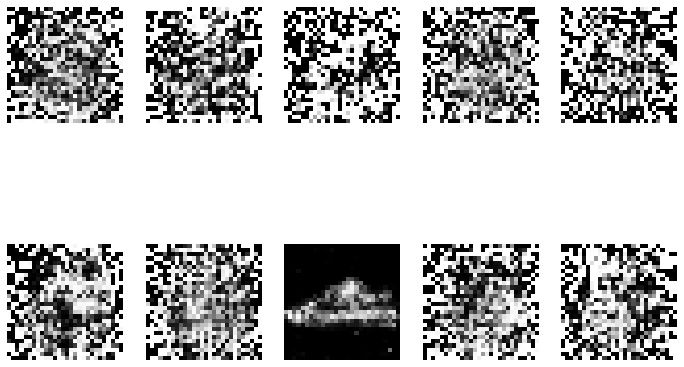

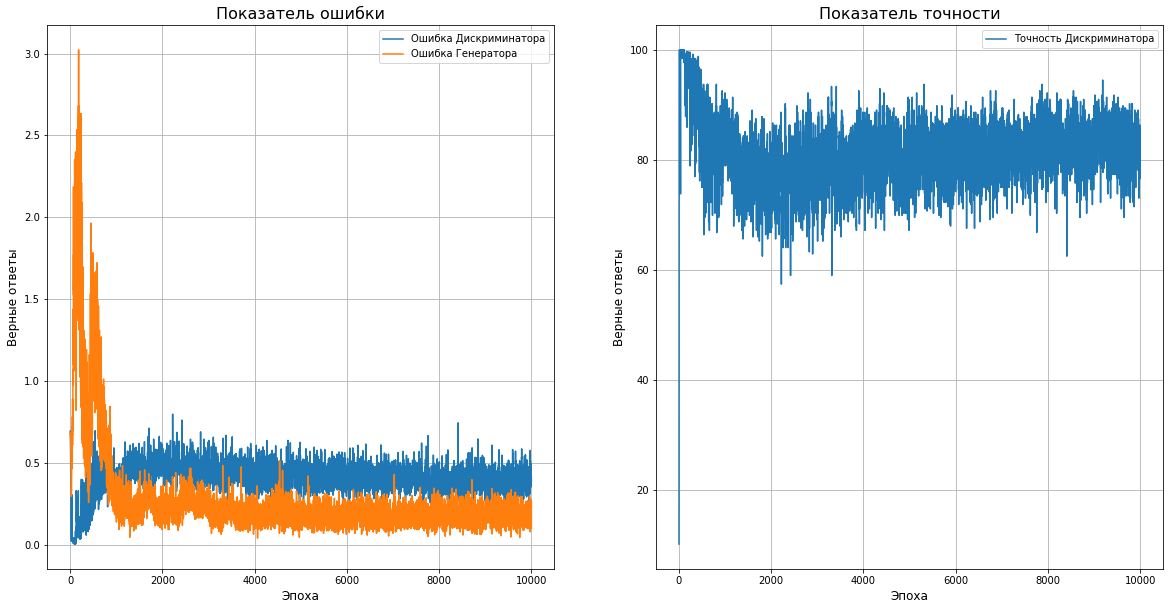

In [ ]:
# Запускаем Функции
generator_cgan2 = create_generator_cgan2()
discriminator_cgan2 = create_discriminator_cgan2()
train_cgan2(generator_cgan2, discriminator_cgan2, epochs=epochs, batch_size=128)